In [1]:
import warnings
import awkward as ak
import numpy as np
import hist as hs
from hist.intervals import ratio_uncertainty

from coffea import processor
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date
today = date.today()

plt.style.use(hep.style.CMS)
#plt.style.use('dark_background')

In [66]:
class LLP_ntuple_processor(processor.ProcessorABC):
    
    def delta_cls_gLLP(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'E': ak.zeros_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        gLLPs = ak.zip(
            {
                'pt': events.gLLP_pt,
                'phi': events.gLLP_phi,
                'eta': events.gLLP_eta,
                'E': events.gLLP_e,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )        
        cls_llp_pairs = ak.cartesian({
            "cls": clusts, 
            "llp": gLLPs
        }, nested = True) 
        
        deltaR = (cls_llp_pairs.cls).delta_r(cls_llp_pairs.llp)
        deltaEta = abs(cls_llp_pairs.cls.eta - cls_llp_pairs.llp.eta)
        deltaPhi = np.arctan2(np.sin(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi), 
                              np.cos(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi))
        
        return ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)
    
    def delta_cls_leadmuon(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'E': ak.zeros_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        leadMuons = ak.zip(
            {
                'pt': events.leadMuonPt,
                'phi': events.leadMuonPhi,
                'eta': events.leadMuonEta,
                'E': events.leadMuonE,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          ) 
        cls_muon_pairs = ak.cartesian({
            "cls": clusts, 
            "muon": leadMuons
        }, nested = True)
 
        deltaR = (cls_muon_pairs.cls).delta_r(cls_muon_pairs.muon)
        deltaEta = abs(cls_muon_pairs.cls.eta - cls_muon_pairs.muon.eta)
        deltaPhi = np.arctan2(np.sin(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi), 
                              np.cos(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi))
        
        return ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)
        
    
    def process(self, events):
        
        # >>> output dict init >>>
        dataset = events.metadata['dataset']
        out = {
            dataset: {},
            f'{dataset}_cuts': {},
            f'{dataset}_vars': {},
        }
        # <<< output dict init <<<
            
        # >>> some preprocessing >>>
        muoncut = abs(events.lepPdgId) == 13
        events['muonE'] = events.lepE[muoncut]
        events['muonPt'] = events.lepPt[muoncut]
        events['muonEta'] = events.lepEta[muoncut]
        events['muonPhi'] = events.lepPhi[muoncut]
        events['muonPdgId'] = events.lepPdgId[muoncut]
        events['muonDZ'] = events.lepDZ[muoncut]
        events['muonLooseId'] = events.lepLooseId[muoncut]
        events['muonTightId'] = events.lepTightId[muoncut]  
        
        muoncut = abs(events.muonEta) < 1.5
        events['muonE'] = events.muonE[muoncut]
        events['muonPt'] = events.muonPt[muoncut]
        events['muonEta'] = events.muonEta[muoncut]
        events['muonPhi'] = events.muonPhi[muoncut]
        events['muonPdgId'] = events.muonPdgId[muoncut]
        events['muonDZ'] = events.muonDZ[muoncut]
        events['muonLooseId'] = events.muonLooseId[muoncut]
        events['muonTightId'] = events.muonTightId[muoncut]

        events = events[(ak.count(events.muonPhi, axis=1) > 0)] #just kill all events with no muons
        leadcut = (ak.max(events.muonPt, axis=1, mask_identity=True) == events.muonPt)
        events['leadMuonE'] = ak.flatten(events.muonE[leadcut])
        events['leadMuonPt'] = ak.flatten(events.muonPt[leadcut])
        events['leadMuonEta'] = ak.flatten(events.muonEta[leadcut])
        events['leadMuonPhi'] = ak.flatten(events.muonPhi[leadcut])
        events['leadMuonPdgId'] = ak.flatten(events.muonPdgId[leadcut])
        events['leadMuonDZ'] = ak.flatten(events.muonDZ[leadcut])
        events['leadMuonLooseId'] = ak.flatten(events.muonLooseId[leadcut])
        events['leadMuonTightId'] = ak.flatten(events.muonTightId[leadcut])
        
        if events.metadata['dataset'] == 'signal':
            cls_llp_deltaR, cls_llp_deltaEta, cls_llp_deltaPhi = self.delta_cls_gLLP(events)
            events['cscRechitCluster_llp_deltaR'] = cls_llp_deltaR
            events['cscRechitCluster_llp_deltaEta'] = cls_llp_deltaEta
            events['cscRechitCluster_llp_deltaPhi'] = cls_llp_deltaPhi

        cls_leadmuon_deltaR, cls_leadmuon_deltaEta, cls_leadmuon_deltaPhi = self.delta_cls_leadmuon(events)
        events['cscRechitCluster_leadmuon_deltaR'] = cls_leadmuon_deltaR
        events['cscRechitCluster_leadmuon_deltaEta'] = cls_leadmuon_deltaEta
        events['cscRechitCluster_leadmuon_deltaPhi'] = cls_leadmuon_deltaPhi
        
        HLT_MU_IP_sel = range(1157,1197)
        events = events[ak.any(events.HLTDecision[:,HLT_MU_IP_sel], axis=1)]
        # <<< some preprocessing <<<


        # >>> cut definitions >>>        
        cscCuts = {'no_cut': ak.values_astype(ak.ones_like(events.nCscRechitClusters), 'bool')} #dummy truth vector of same shape as csc variables
        
        cscCuts['llp_csc_cut'] = (events.nCscRechitClusters >= 1)
        if dataset == 'signal':
            cscCuts['llp_csc_cut'] = cscCuts['llp_csc_cut'] & (events.gLLP_csc == 1) 
            
        cscCuts['cls_leadmuon_deltaR_cut'] = (events.cscRechitCluster_leadmuon_deltaR > 1.) 
        #cscCuts['met_cut'] = (events.metEENoise >= 30)

        '''
        if dataset == 'signal':
            cscCuts['cls_llp_deltaR_match_cut'] = ak.flatten((ak.min(events.cscRechitCluster_llp_deltaR, axis=2) == events.cscRechitCluster_llp_deltaR), axis=2)
            cscCuts['cls_llp_deltaR_cut'] = ak.flatten((events.cscRechitCluster_llp_deltaR < .4), axis=2)
        '''
        
        cscCuts['ME11_veto'] = ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&
                             (events.cscRechitClusterNRechitChamberMinus11 <= 0)) 
        
        cscCuts['ME12_veto'] = ((events.cscRechitClusterNRechitChamberPlus12 <= 0)&
                             (events.cscRechitClusterNRechitChamberMinus12 <= 0)) 
        
        cscCuts['re12_cut'] = (events.cscRechitCluster_match_RE12_0p4 == 0)
        cscCuts['mb1_cut'] = (events.cscRechitCluster_match_MB1Seg_0p4 == 0)
        cscCuts['rb1_cut'] = (events.cscRechitCluster_match_RB1_0p4 == 0)
        cscCuts['muon_veto'] = (events.cscRechitClusterMuonVetoPt < 20)
        
        cscCuts['cls_time_cut'] = ((events.cscRechitClusterTimeWeighted <= 12.5)&
                                   (events.cscRechitClusterTimeWeighted >= -5  ))
        
        cscCuts['cls_timeSpread_cut'] = (events.cscRechitClusterTimeSpreadWeightedAll <= 20)
        cscCuts['cls_eta_cut'] = (abs(events.cscRechitClusterEta) < 1.9)
        cscCuts['cls_size_cut'] = (events.cscRechitClusterSize > 130)
        # <<< cut definitions <<<

        # >>> variables to be plotted >>>                
        __ = lambda x: x
        bins = 30
        
        #must be same shape as any csc variable
        cscVars = {
            'cscRechitClusterNRechitChamberPlus11':  [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberMinus11': [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberPlus12':  [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberMinus12': [bins,    0,  10, __, ],
            'cscRechitCluster_match_RE12_0p4':       [bins,    0,  10, __, ],
            'cscRechitCluster_match_MB1Seg_0p4':     [bins,    0,  10, __, ],
            'cscRechitCluster_match_RB1_0p4':        [bins,    0,  10, __, ],
            'cscRechitClusterMuonVetoPt':            [bins,    0, 100, __, ],
            'cscRechitClusterTimeWeighted':          [bins,  -20,  20, __, ],
            'cscRechitClusterTimeSpreadWeightedAll': [bins,    0,  30, __, ],
            'cscRechitClusterEta':                   [bins,    0,   3, abs,],
            'cscRechitClusterSize':                  [bins,    0, 250, __, ],
            'cscRechitClusterNStation10':            [bins,    0,   5, __, ],
            'cscRechitClusterAvgStation10':          [bins,    0,   5, abs, ],
        }

        if dataset == 'signal':
            cscVars['cscRechitCluster_llp_deltaR']   = [bins, 0, 5, __,]
            cscVars['cscRechitCluster_llp_deltaEta'] = [bins, 0, 5, abs,]
            cscVars['cscRechitCluster_llp_deltaPhi'] = [bins, 0, 5, __,]

        cscVars['cscRechitCluster_leadmuon_deltaR']   = [bins, 0, 5, __,]
        cscVars['cscRechitCluster_leadmuon_deltaEta'] = [bins, 0, 5, abs,]
        cscVars['cscRechitCluster_leadmuon_deltaPhi'] = [bins, 0, 5, __,]
        
        #must be flat variables of length nEvents
        eventVars = {
            #'metEENoise': [bins,   0, 100, __, ],
        }
        # <<< variables to be plotted <<<



        # >>> create hists >>>  
        for i in range(1,4):
            if i < 3:
                bigCut = (events.cscRechitClusterNStation10 == i)
            else:
                bigCut = (events.cscRechitClusterNStation10 >= 3)
            
            for cut in cscCuts:
                out[f'{dataset}_cuts'][cut] = 1       
                bigCut = bigCut & cscCuts[cut]

                if bigCut.layout.minmax_depth == (2,2):
                    temp = sum(ak.any(bigCut, axis=1))
                elif bigCut.layout.minmax_depth == (1,1):
                    temp = sum(bigCut)

                out[dataset][f'numEvents_{cut}_NStation10=={i}'] = temp

                for var in cscVars:
                    out[f'{dataset}_vars'][var] = 1  
                    v = cscVars[var]
                    data = ak.flatten(events[var][bigCut], axis=None)
                    data = v[3](data)
                    key = f'{var} with {cut} and NStation10=={i}'
                    out[dataset][key] = hs.Hist.new.Reg(v[0], v[1], v[2], name=var, label=var).Double()
                    out[dataset][key].fill(data) 
                
        bigCut = cscCuts['no_cut']
        for cut in cscCuts:
            out[f'{dataset}_cuts'][cut] = 1       
            bigCut = bigCut & cscCuts[cut]
            
            
            if bigCut.layout.minmax_depth == (2,2):
                temp = sum(ak.any(bigCut, axis=1))
            elif bigCut.layout.minmax_depth == (1,1):
                temp = sum(bigCut)
                            
            out[dataset][f'numEvents_{cut}'] = temp

            for var in cscVars:
                out[f'{dataset}_vars'][var] = 1  
                v = cscVars[var]
                data = ak.flatten(events[var][bigCut], axis=None)
                data = v[3](data)
                key = f'{var} with {cut}'
                out[dataset][key] = hs.Hist.new.Reg(v[0], v[1], v[2], name=var, label=var).Double()
                out[dataset][key].fill(data) 
                   
        
        # <<< create hists <<<
        
        
        return out
    
    def postprocess(self, accumulator):
        return accumulator
    

In [67]:
fileset = {}
fileset['signal']     = ['root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/v3/normalized/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root',]
fileset['background'] = ['root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/csc/V1p171/Data2018_UL/v3/normalized/ParkingBPH4_Run2018A_goodLumi.root']
out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 16},
    #executor_args={"schema": BaseSchema, "workers": 1},
    #maxchunks = 1
    #chunksize=100_000_000
)

sigcuts = list(out['signal_cuts'].keys())
bkgcuts = list(out['background_cuts'].keys())

sigvars = list(out['signal_vars'].keys())
bkgvars = list(out['background_vars'].keys())

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219/219 [ 0:06:27 < 0:00:00 | 0.9  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219/219 [ 0:06:28 < 0:00:00 | ?   merges/s ]

In [68]:
datasets = ['signal', 'background']

for dataset in datasets:
    for key in out[dataset]:
        if key.startswith('numEvents_') and ('NStation10' not in key):
            print(f"{key[10:]}, {out[dataset][key]}")
  #          print(f"{out[dataset][key]}")


no_cut, 71387
llp_csc_cut, 1306
cls_leadmuon_deltaR_cut, 1166
ME11_veto, 726
ME12_veto, 559
re12_cut, 553
mb1_cut, 550
rb1_cut, 544
muon_veto, 541
cls_time_cut, 506
cls_timeSpread_cut, 491
cls_eta_cut, 323
cls_size_cut, 84
no_cut, 19272286
llp_csc_cut, 5957582
cls_leadmuon_deltaR_cut, 4388036
ME11_veto, 495875
ME12_veto, 245114
re12_cut, 242729
mb1_cut, 238521
rb1_cut, 237379
muon_veto, 236150
cls_time_cut, 41403
cls_timeSpread_cut, 28296
cls_eta_cut, 5179
cls_size_cut, 171


In [59]:
datasets = ['signal', 'background']

for dataset in datasets:
    for i in range(1,4):
        end = f'_NStation10=={i}'
        print(f'{dataset}, {end}')
        for s in out[dataset]:
            beg = 'numEvents_'
            if s.startswith(beg) and s.endswith(end):
                #print(f"{thing[10:]}, {out[dataset][thing]}")
                print(f"{out[dataset][s]}")


signal, _NStation10==1
2315
906
825
554
414
410
407
404
402
368
357
237
57
signal, _NStation10==2
1156
318
275
161
136
134
134
131
130
129
126
83
26
signal, _NStation10==3
822
107
85
12
10
10
10
10
10
9
8
3
1
background, _NStation10==1
2628595
2628595
2048436
330209
179288
177551
174231
173228
172853
29526
22469
4700
154
background, _NStation10==2
1487102
1487102
1102660
84589
36443
36060
35360
35281
34875
6256
3137
281
13
background, _NStation10==3
1907474
1907474
1276176
81569
29508
29241
29049
28989
28541
5623
2690
198
4


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import warnings

with warnings.catch_warnings(): #i don't need to see all the divide by zero warnings
    warnings.simplefilter("ignore")

    for varname in varnames:
        pdf = PdfPages(f'varPlots_sb_clsCuts_{date}/{varname}_cutflow_sb.pdf')

        for cut in cuts:
            fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))

            signal = out['signal'][f'var: {varname} with cut: {cut}']
            background = out['background'][f'var: {varname} with cut: {cut}']

            hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
            hep.histplot(background/background.sum(), label='background', ax=ax[0])
            ax[0].set_title(f'{varname} with {cut} cut')
            ax[0].legend()
            ax[0].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax[0].set(xlabel=None)
            ax[0].set_yscale('log')

            ratio(signal/signal.sum(), background/background.sum(), ax[1])
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].set(xlabel=varname)
            ax[1].set_yscale('log')
            fig.subplots_adjust(wspace=0, hspace=.05)
            pdf.savefig(fig)
            print(f'var: {varname} with cut: {cut} saved in a pdf')
        pdf.close()


In [70]:
def ratio(num, den, ax):
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax

def sb_plotter(varname, cut):
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))

    signal = out['signal'][f'{varname} with {cut}']
    background = out['background'][f'{varname} with {cut}']

        
    hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
    hep.histplot(background/background.sum(), label='background', ax=ax[0])
    ax[0].set_title(f'{varname} with {cut}')
    ax[0].legend()
    ax[0].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax[0].set(xlabel=None)
    ax[0].set_yscale('log')

    ratio(signal/signal.sum(), background/background.sum(), ax[1])
    ax[1].set_xlim(ax[0].get_xlim())
    #ax[1].set_ylim((0,2))
    ax[1].set(xlabel=varname)
    ax[1].set_yscale('log')
    #fig.subplots_adjust(wspace=0, hspace=.05)
    return fig

def sb_plotter_noratio(varname, cut, ax):
    signal = out['signal'][f'{varname} with {cut}']
    background = out['background'][f'{varname} with {cut}']

        
    hep.histplot(signal/signal.sum(), label='signal', ax=ax)
    hep.histplot(background/background.sum(), label='background', ax=ax)
    ax.set_title(f'{varname} with {cut}')
    ax.legend()
    # ax.tick_params(
    #     axis='x',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     bottom=False,      # ticks along the bottom edge are off
    #     top=False,         # ticks along the top edge are off
    #     labelbottom=False) # labels along the bottom edge are off
    #ax.set(xlabel=None)
    ax.set_yscale('log')

/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


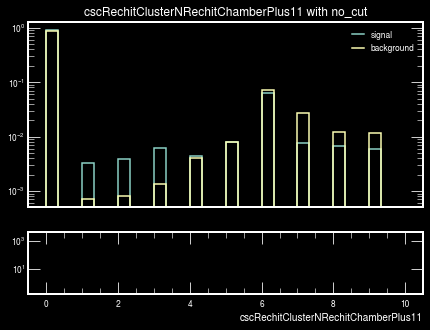

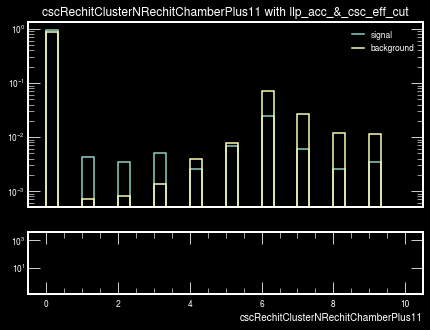

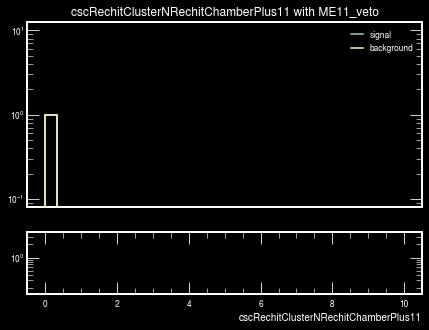

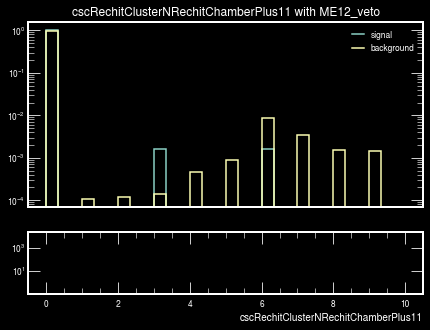

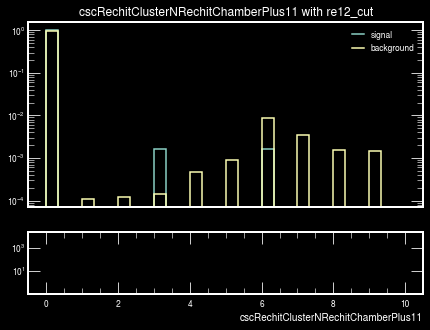

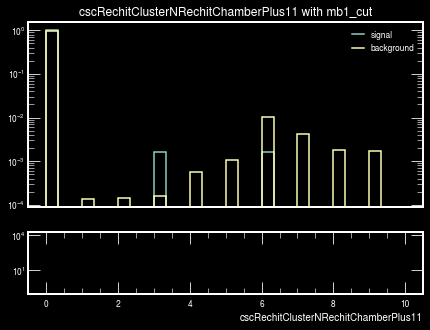

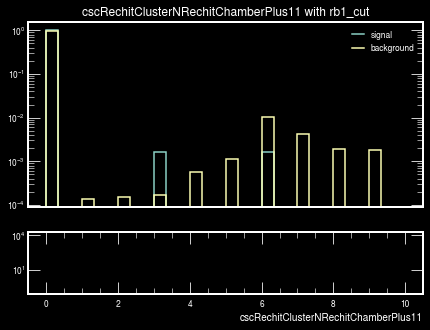

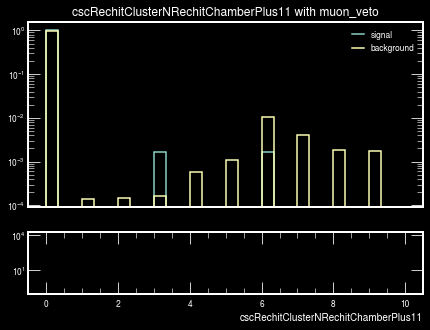

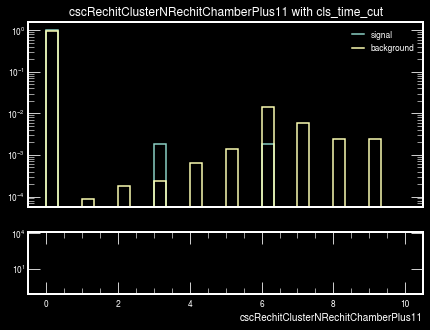

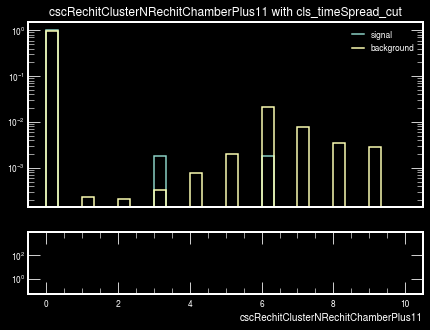

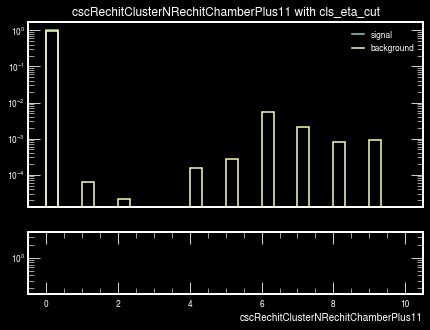

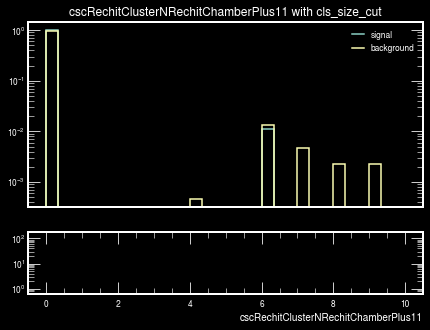

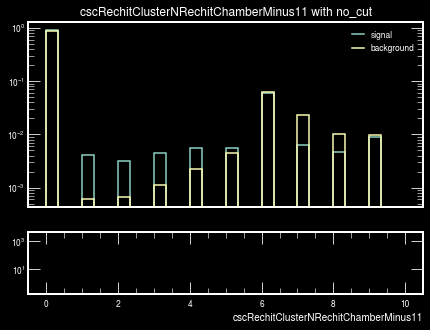

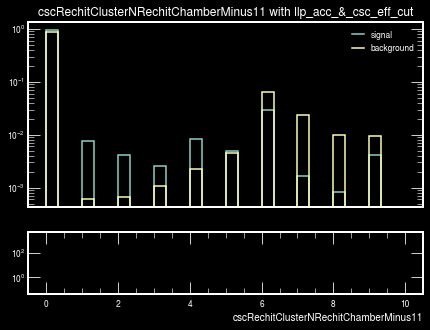

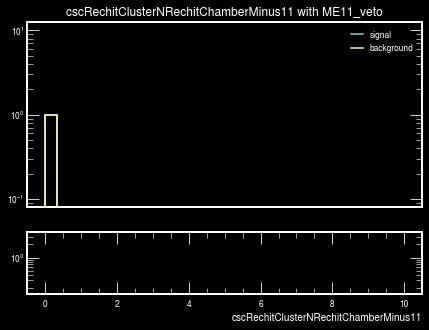

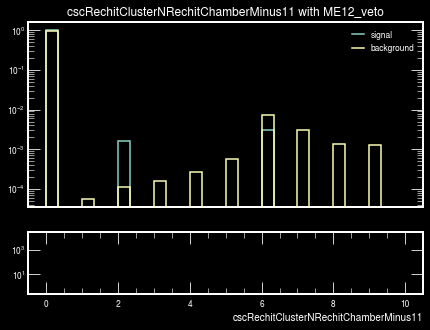

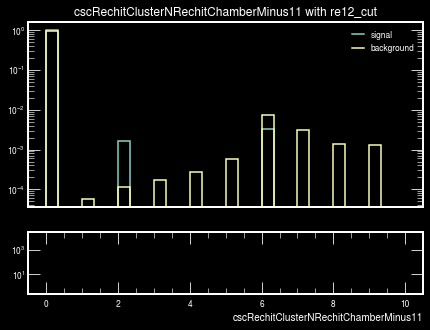

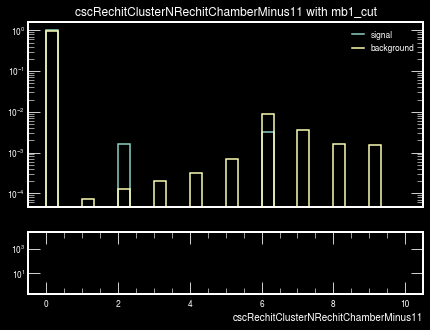

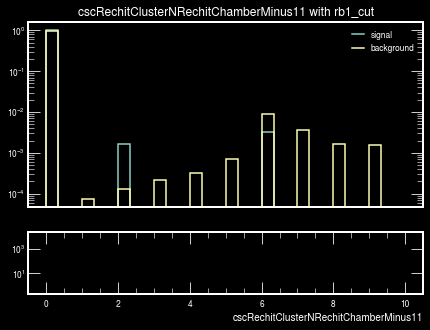

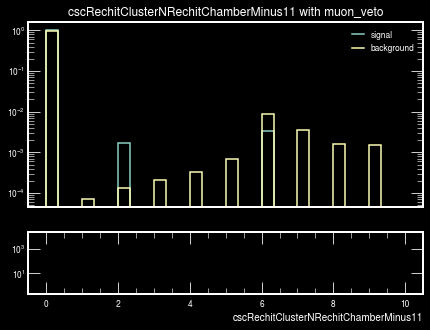

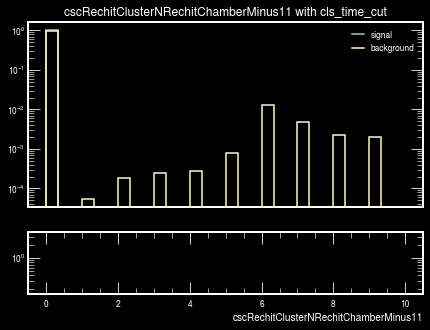

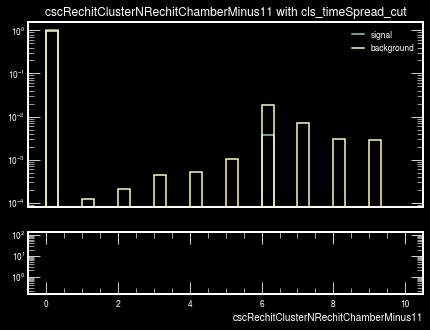

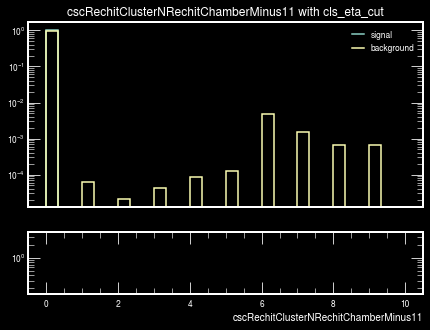

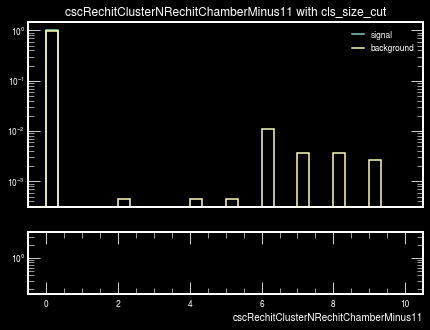

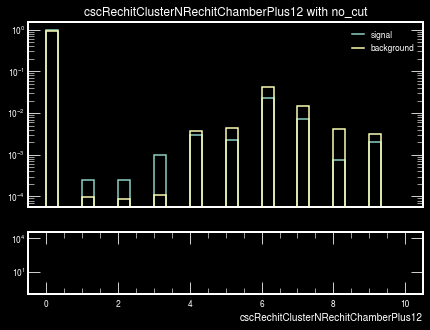

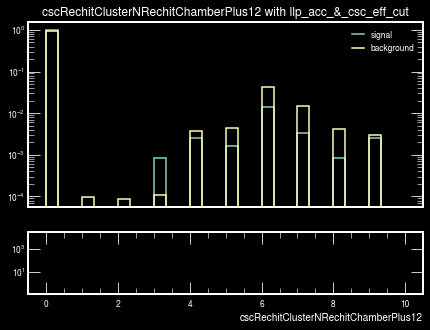

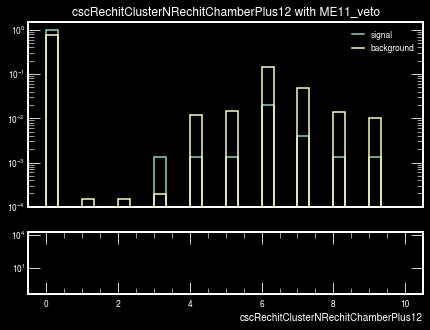

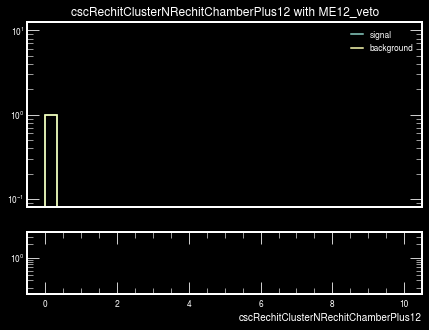

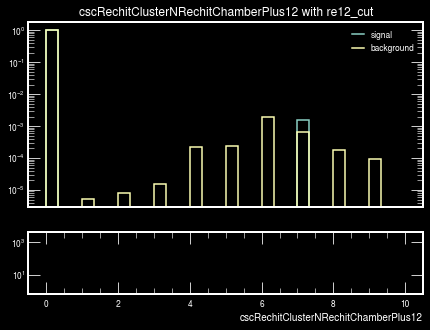

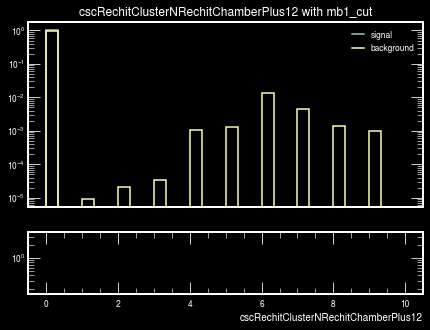

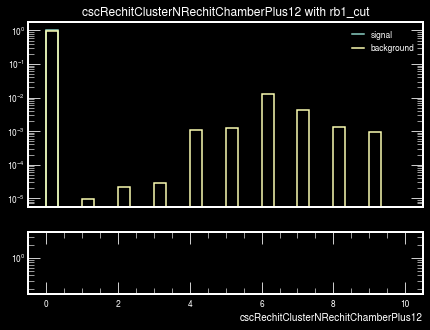

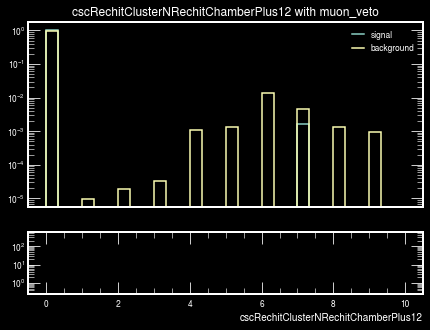

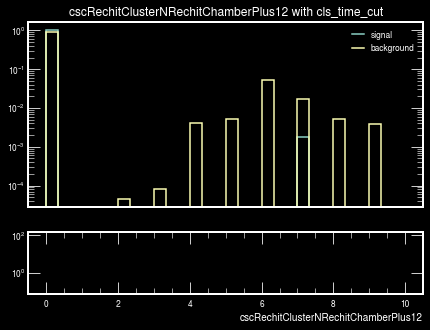

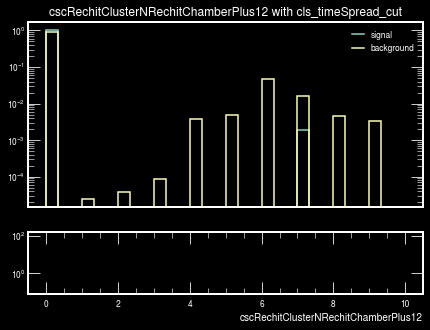

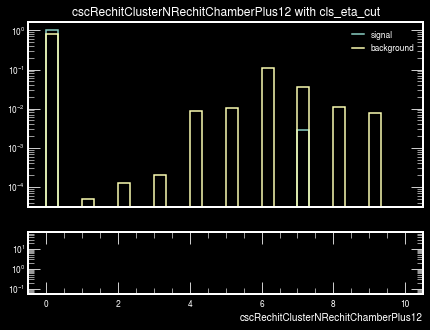

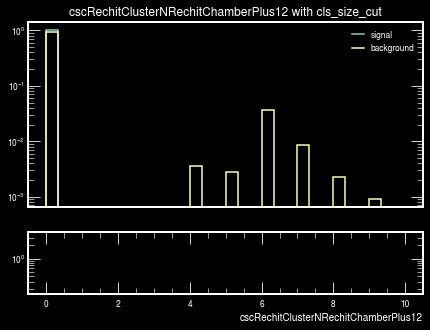

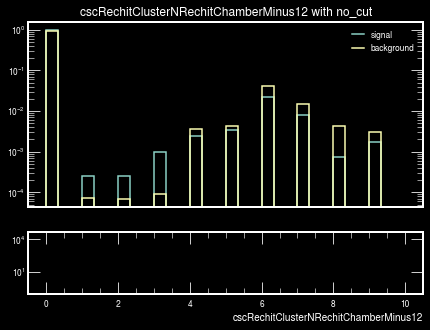

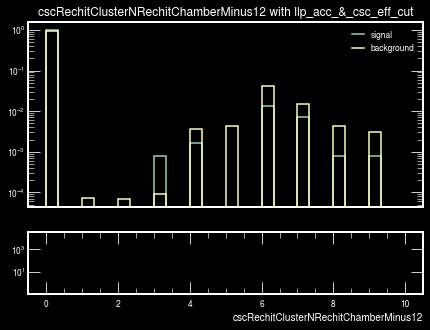

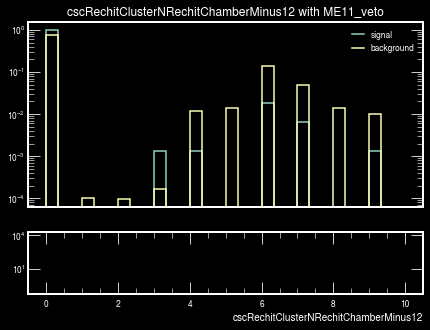

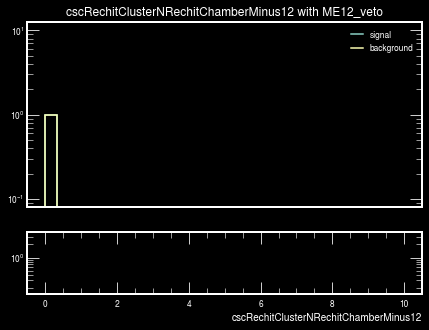

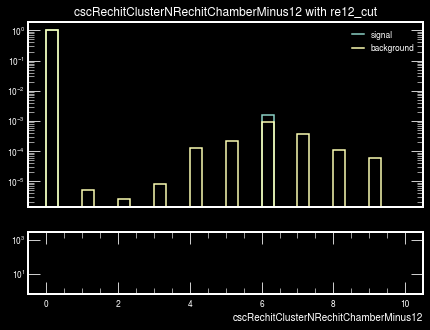

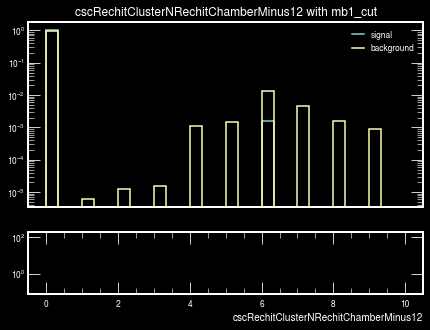

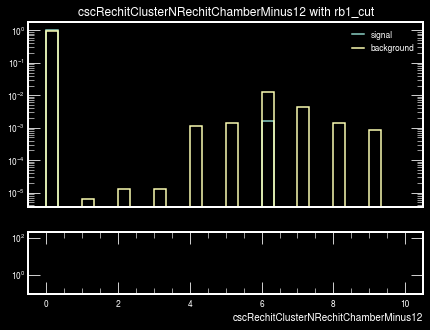

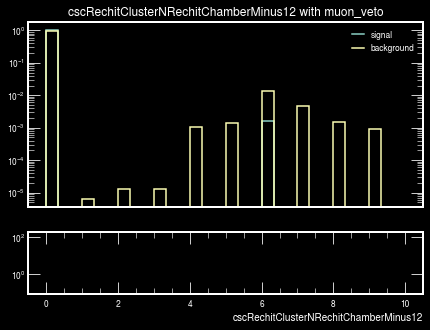

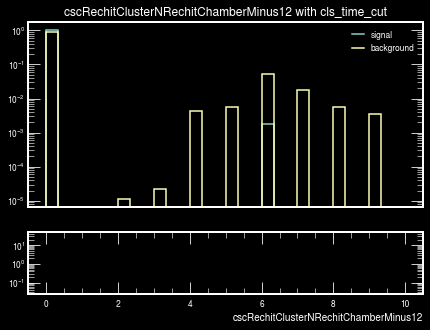

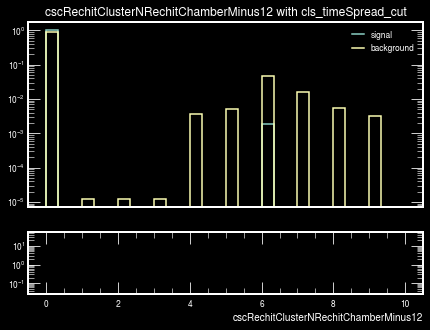

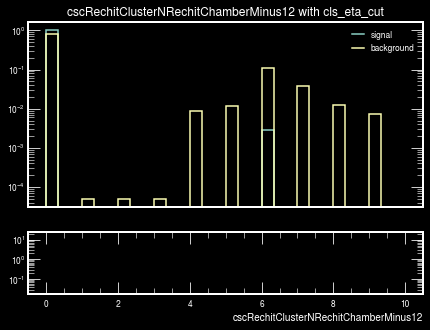

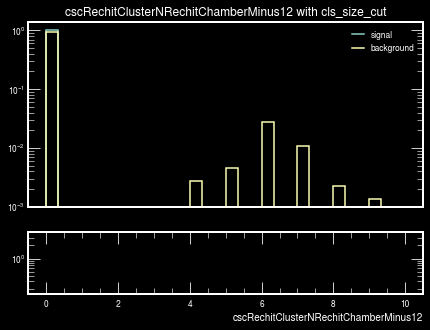

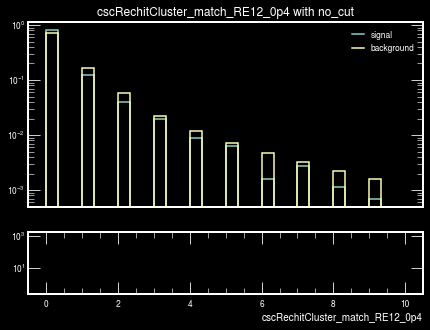

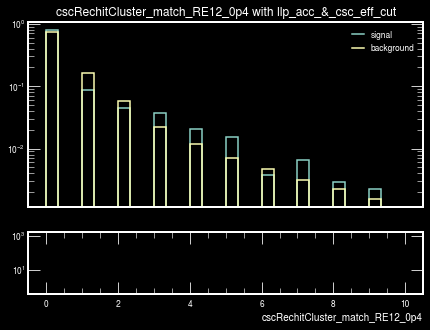

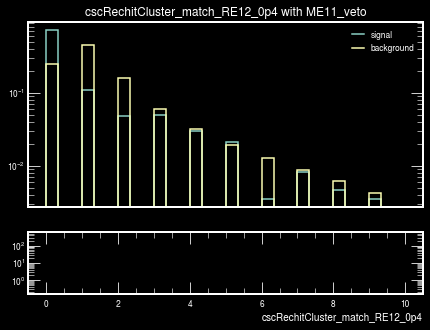

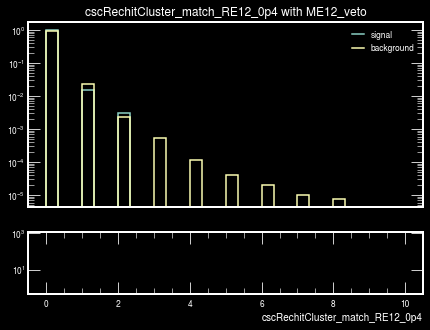

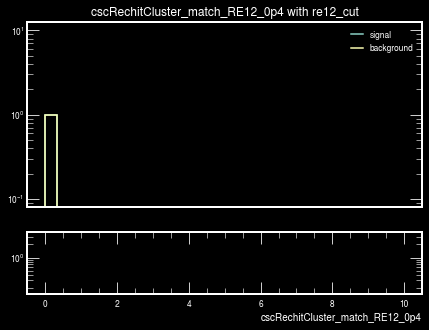

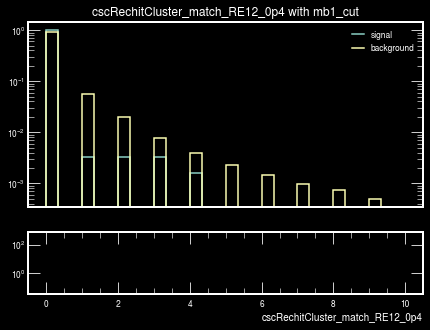

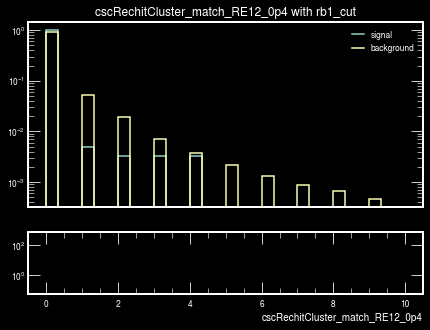

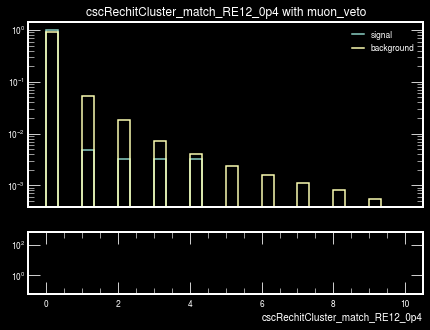

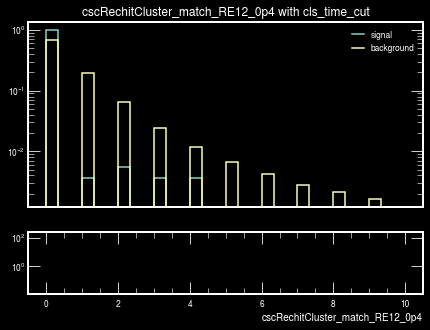

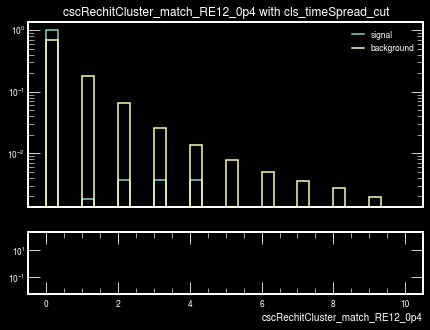

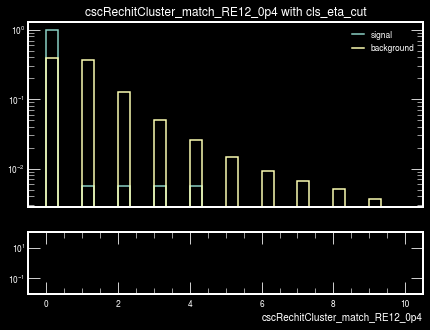

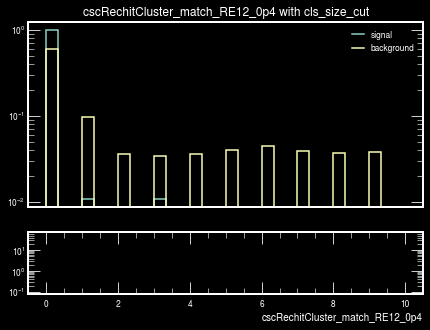

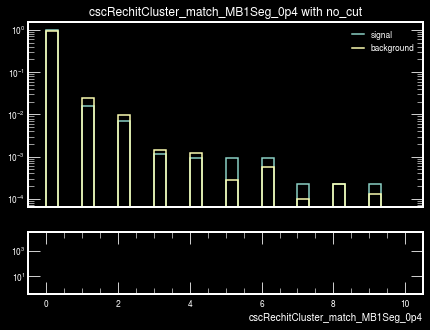

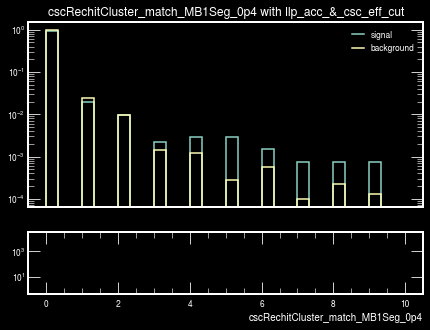

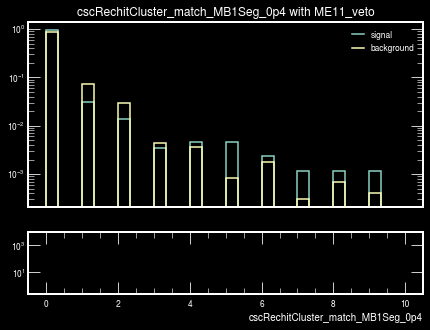

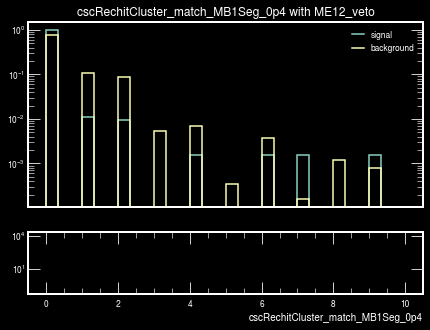

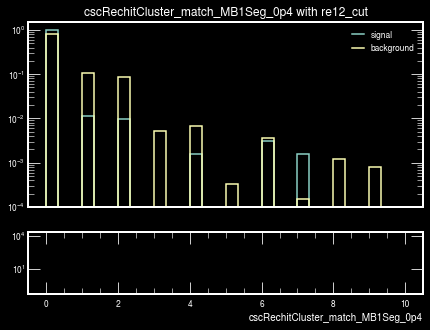

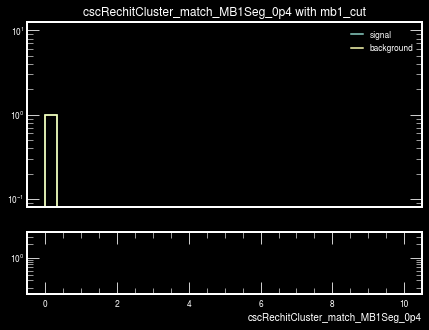

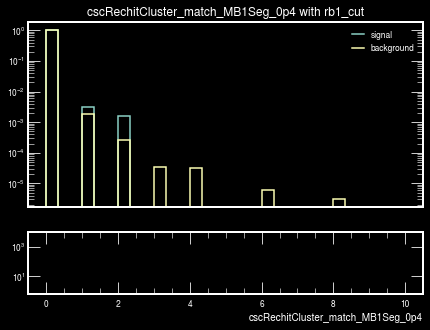

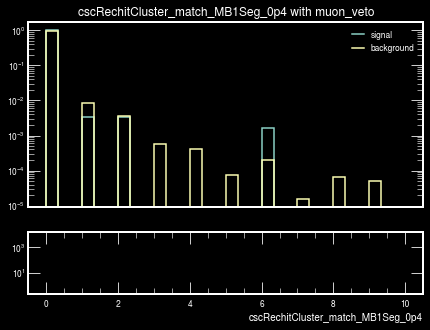

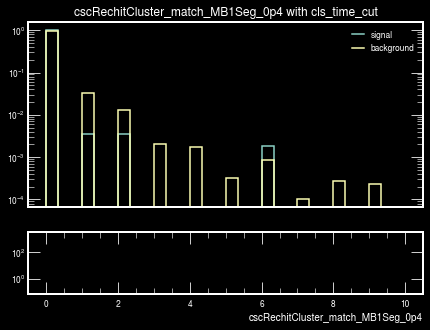

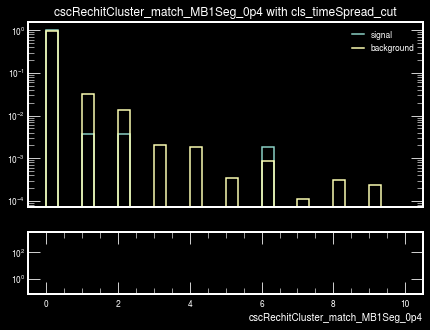

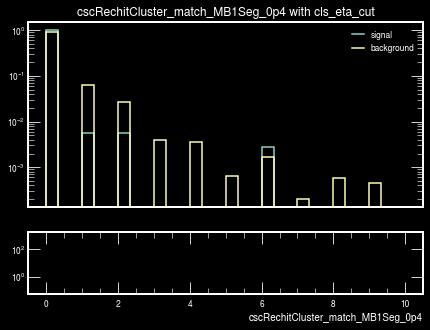

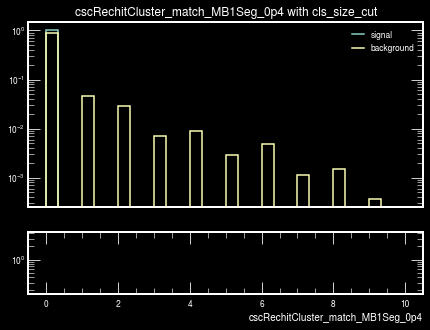

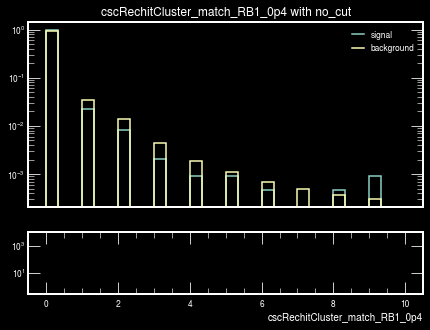

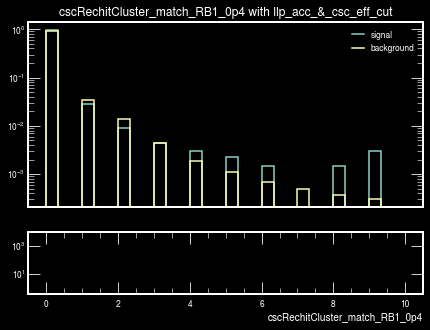

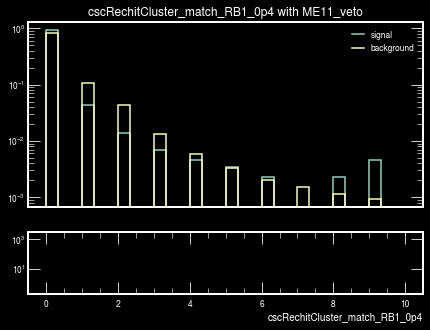

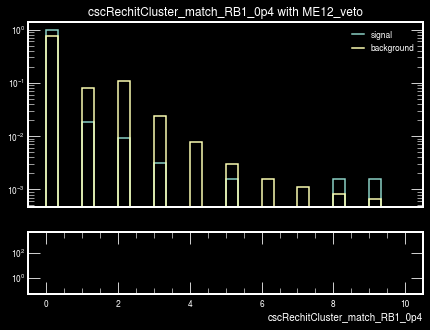

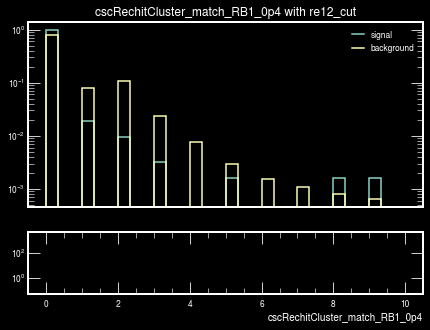

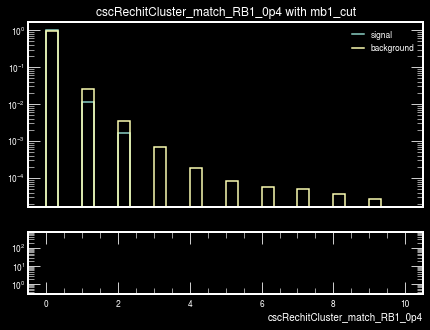

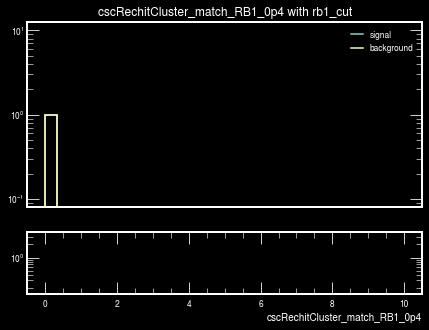

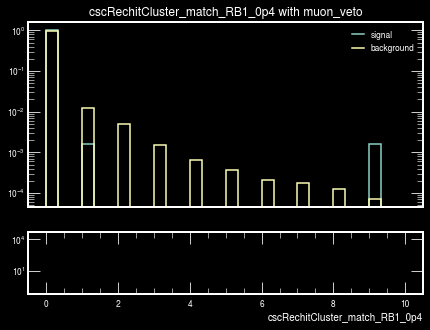

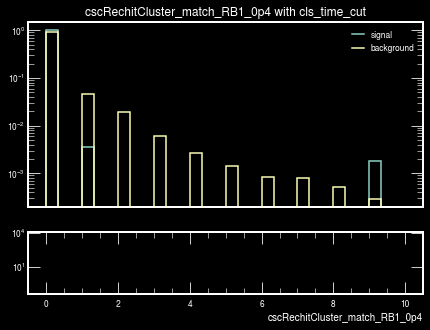

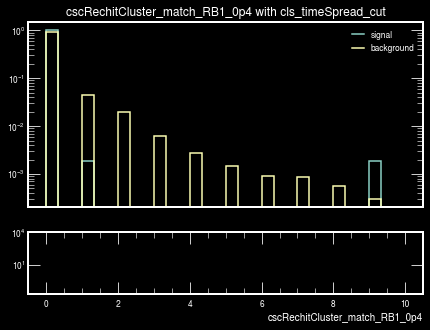

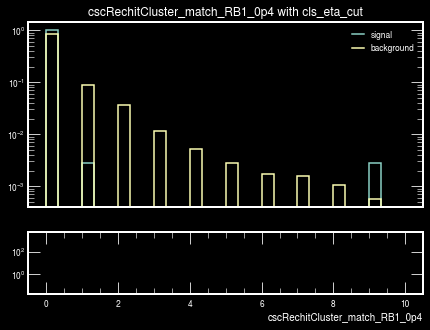

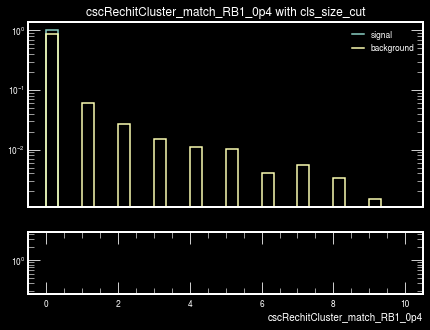

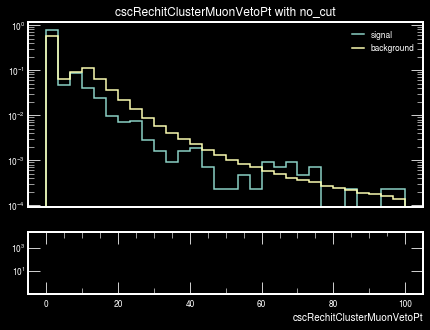

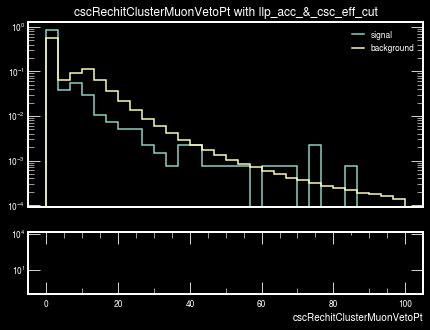

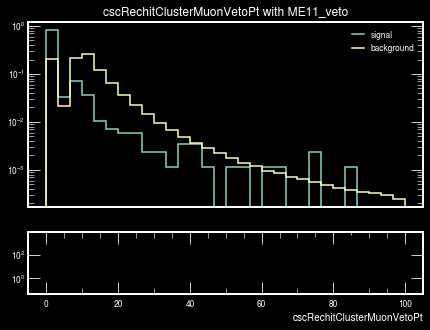

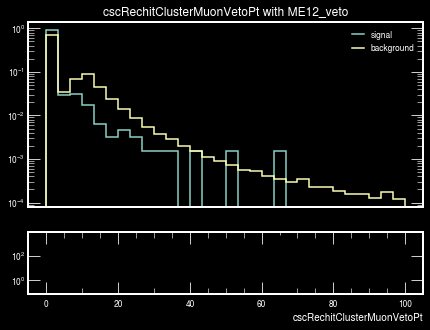

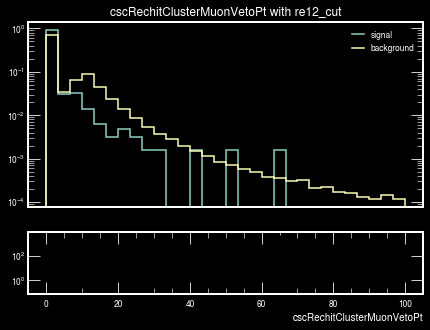

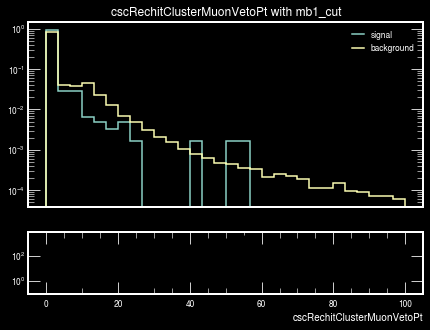

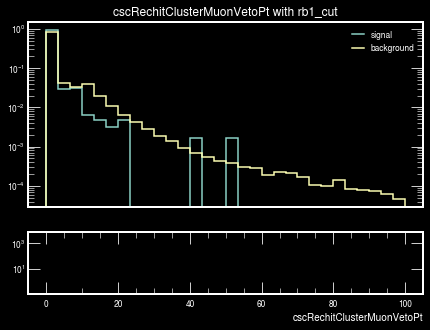

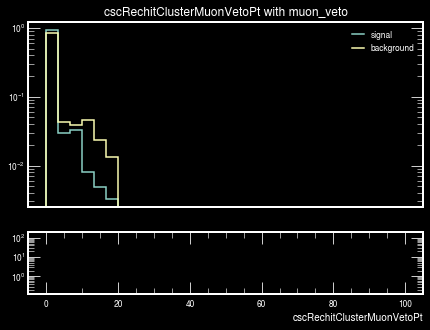

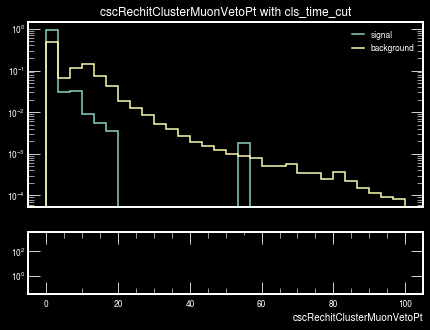

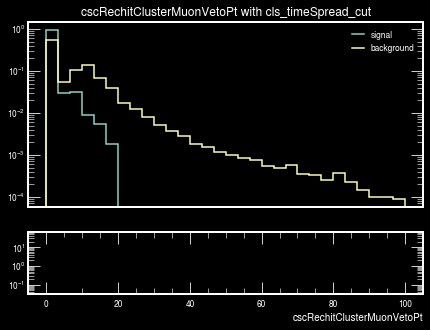

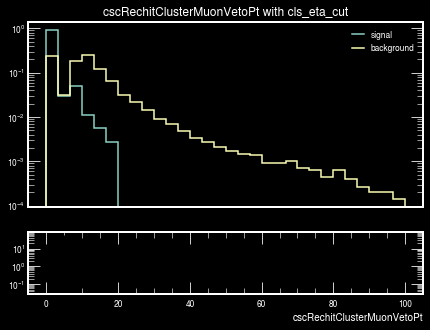

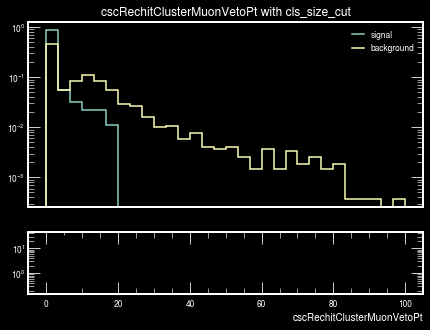

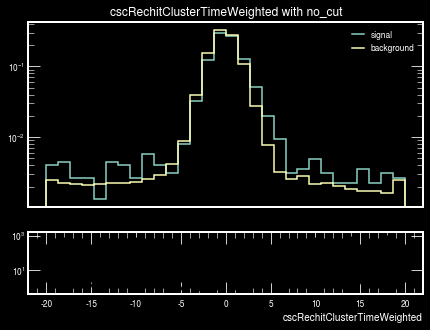

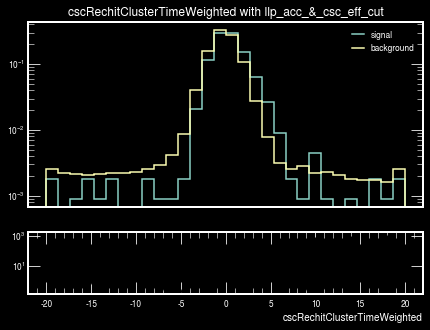

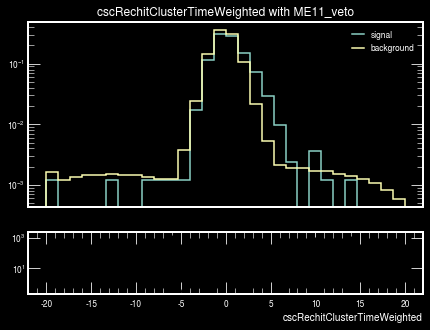

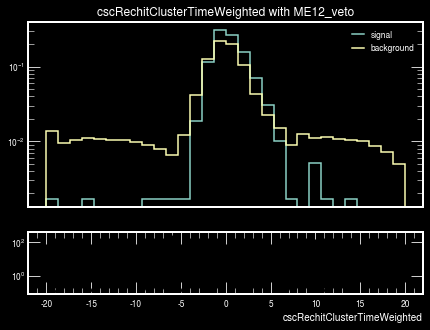

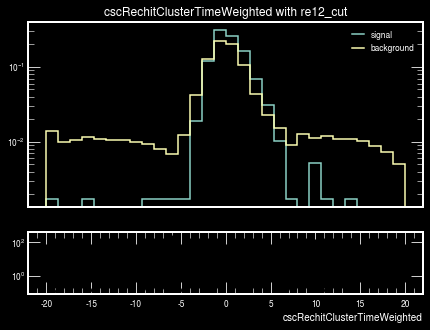

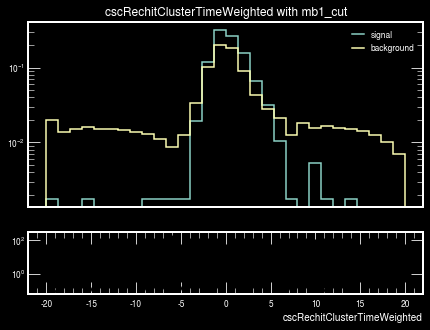

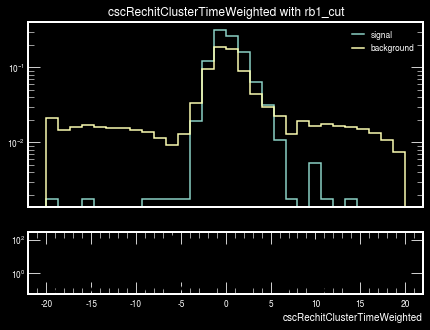

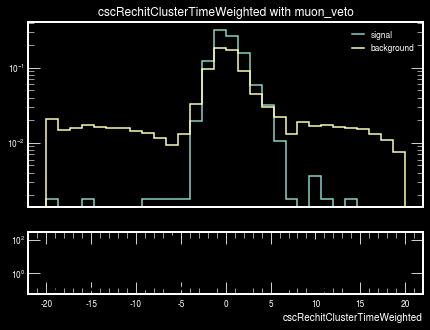

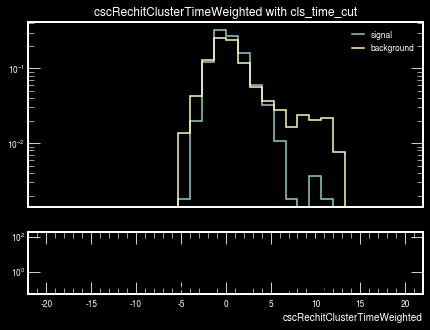

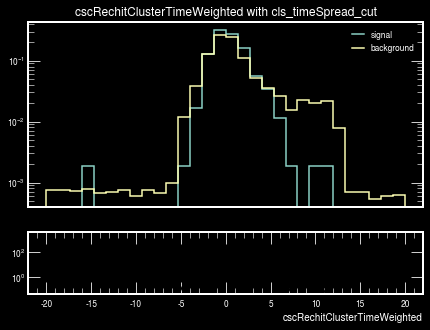

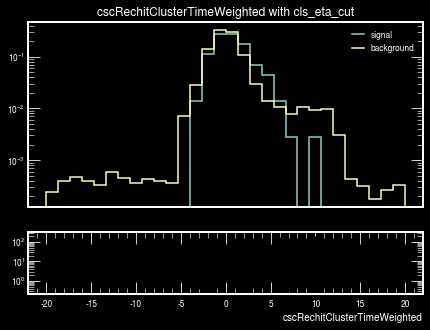

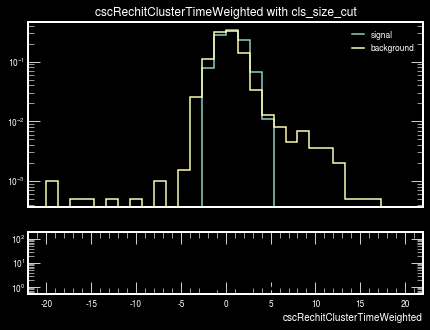

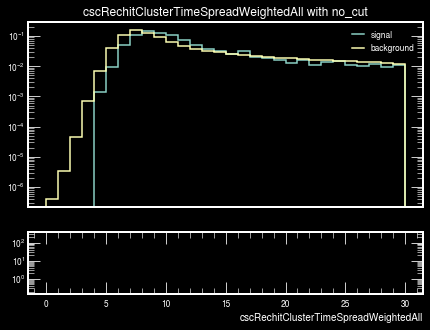

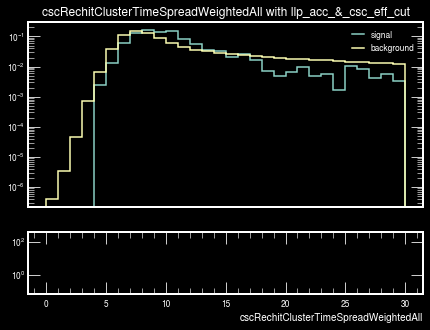

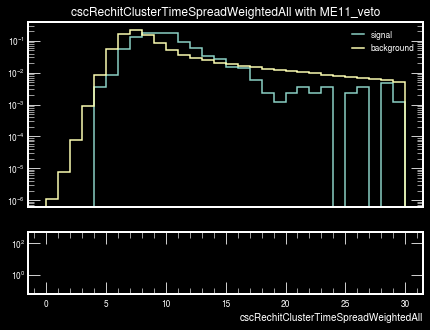

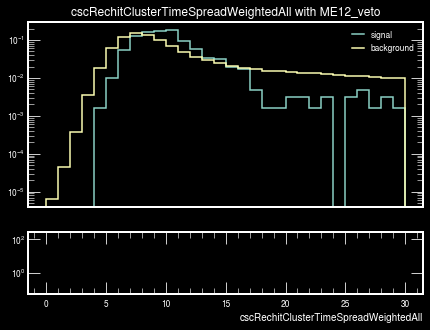

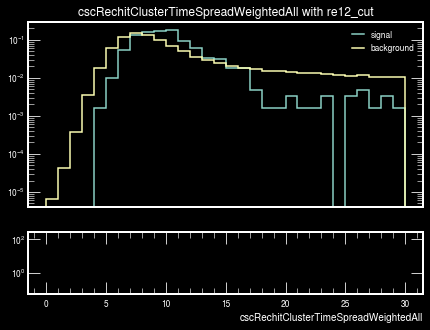

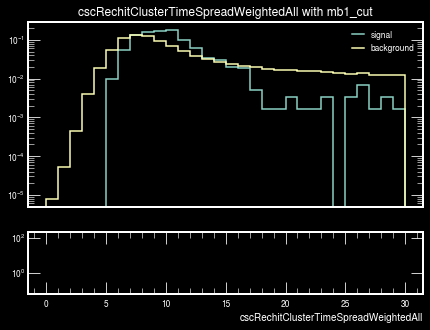

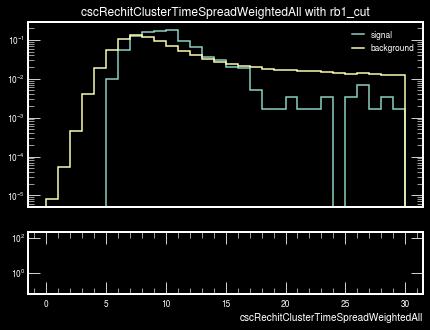

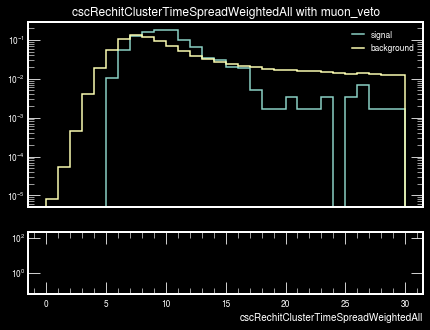

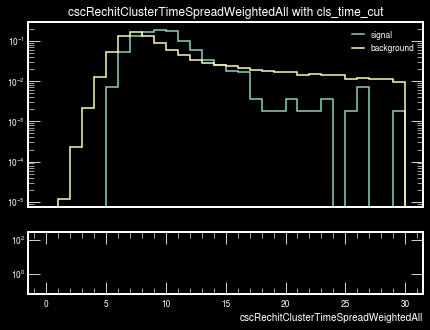

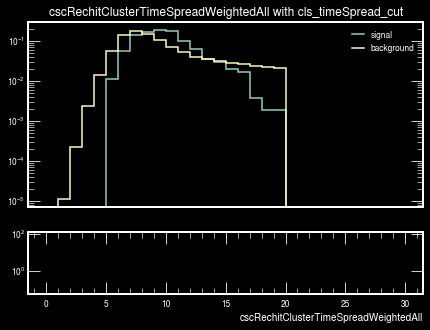

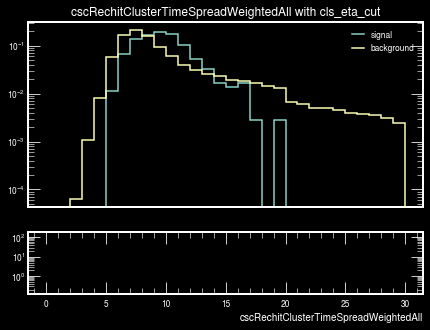

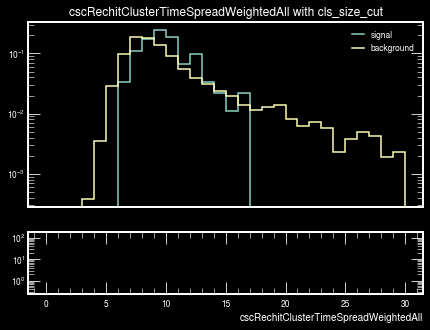

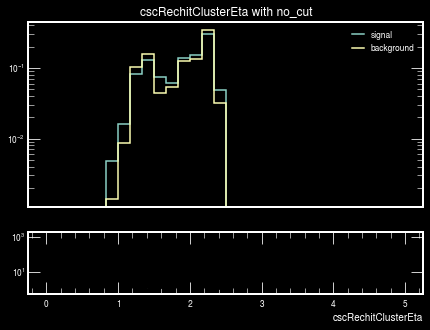

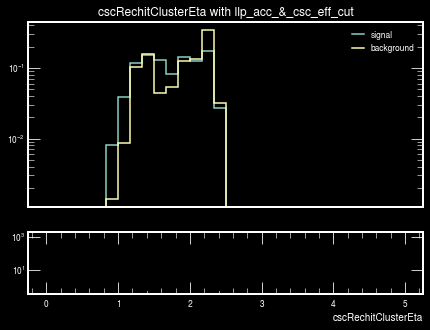

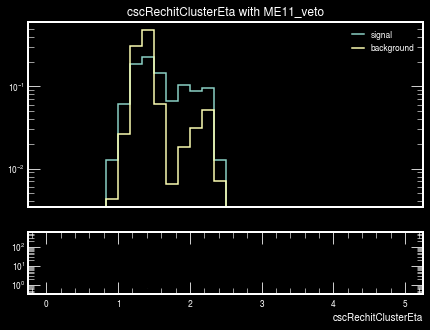

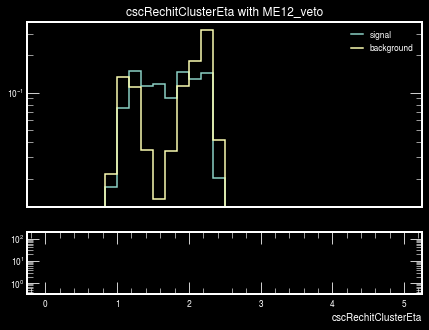

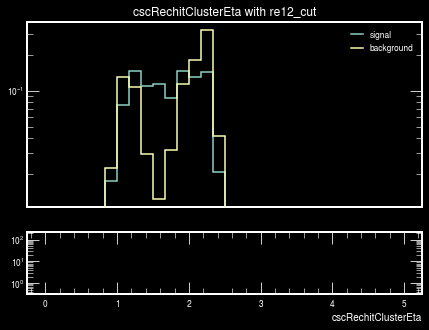

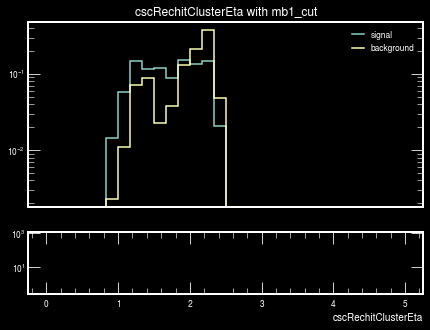

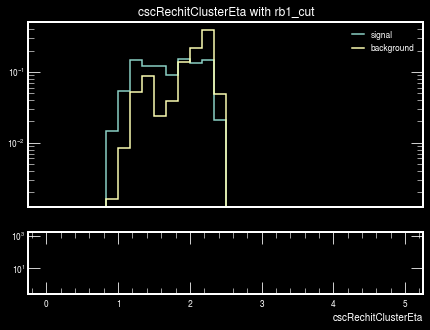

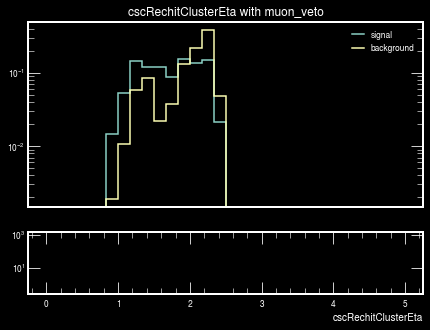

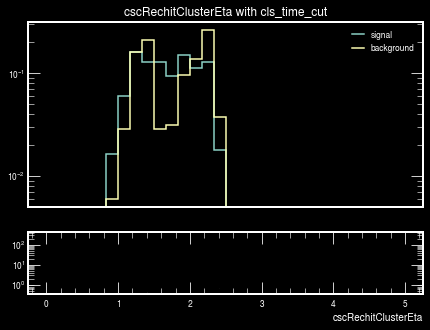

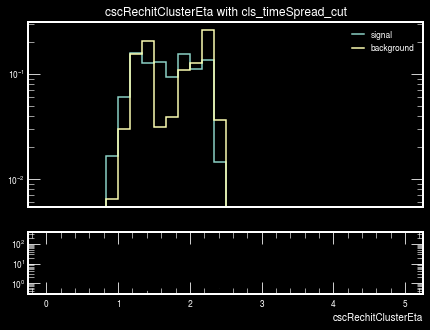

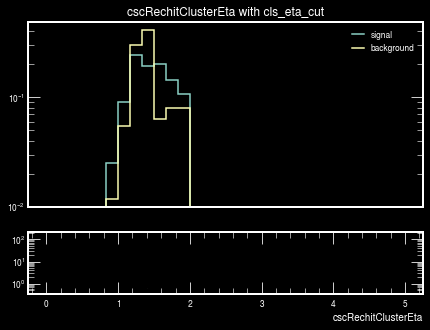

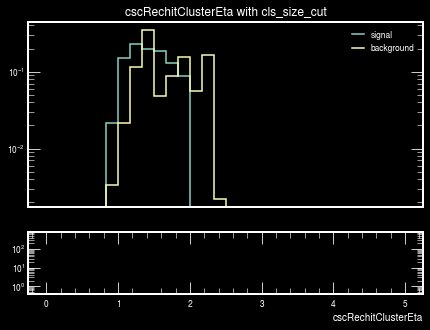

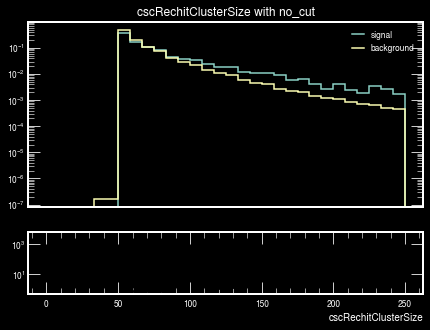

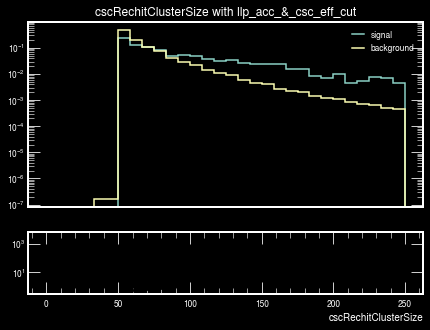

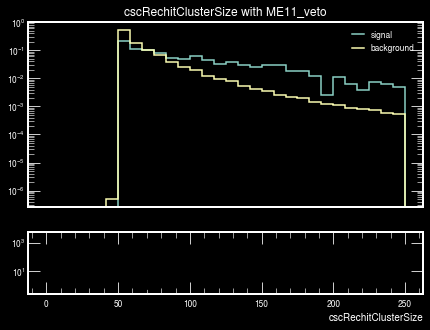

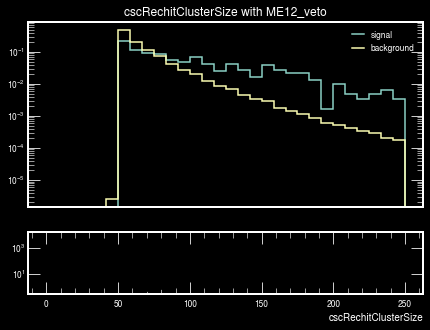

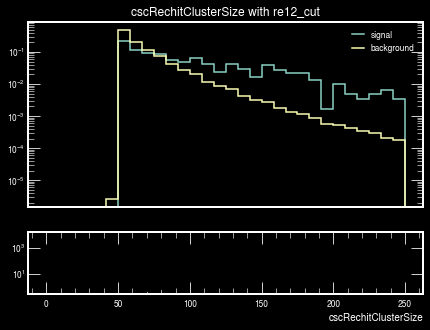

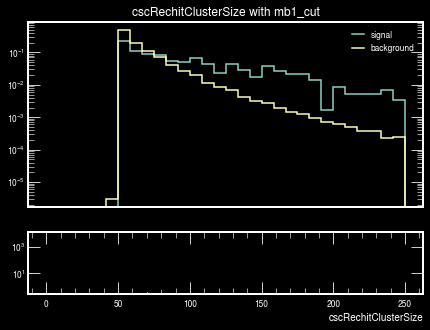

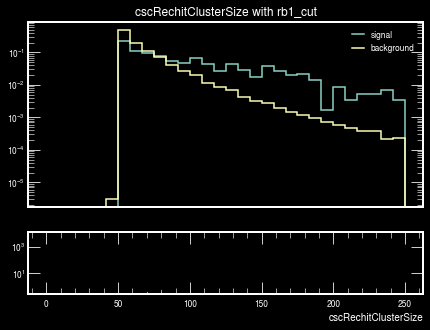

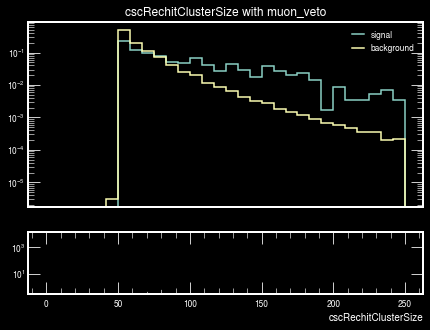

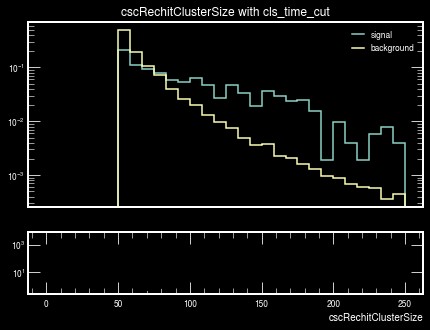

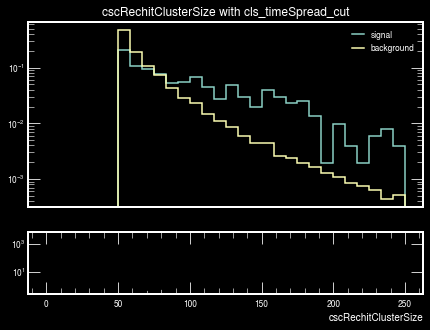

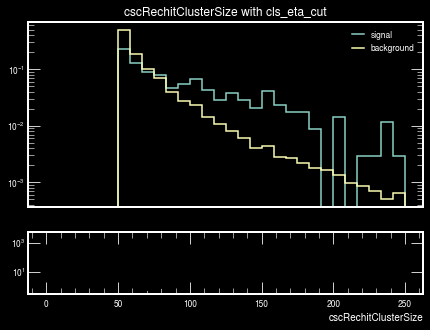

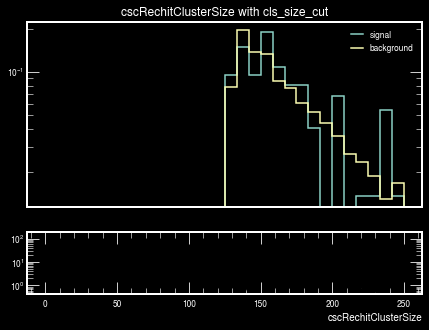

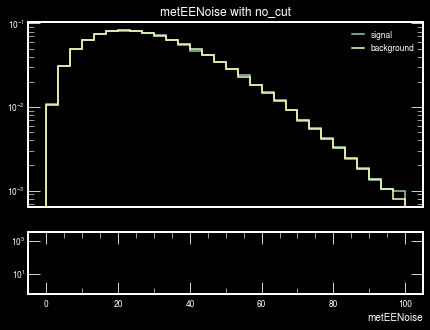

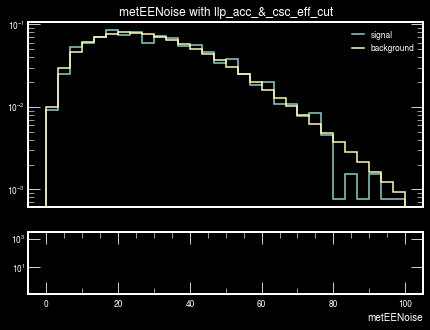

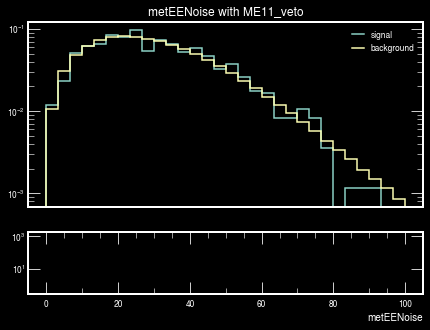

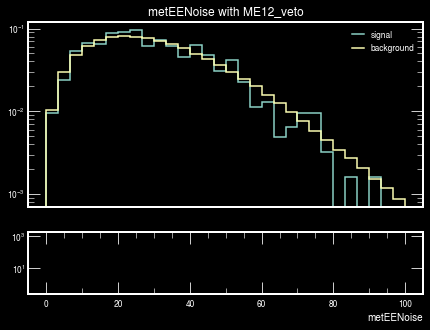

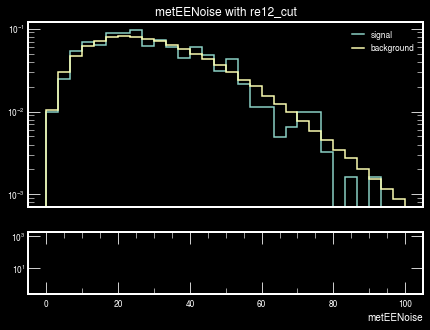

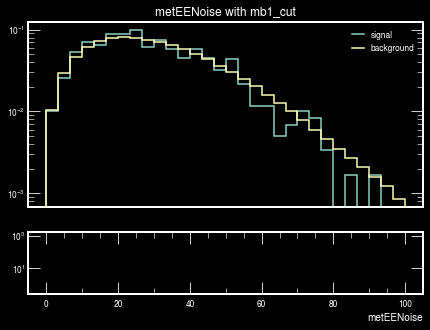

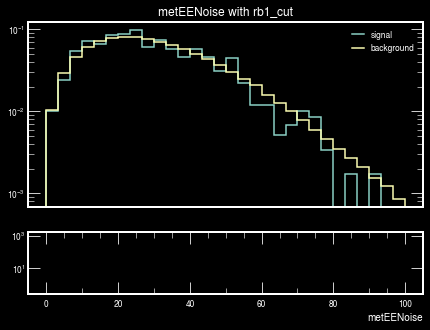

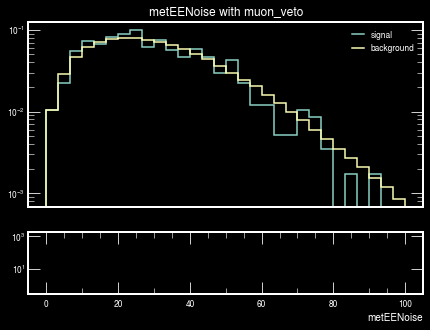

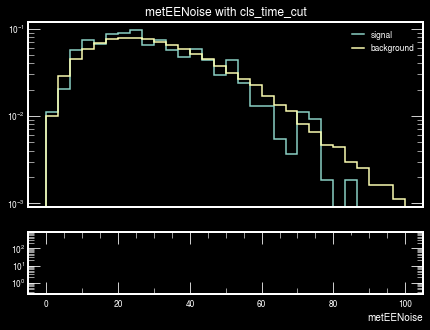

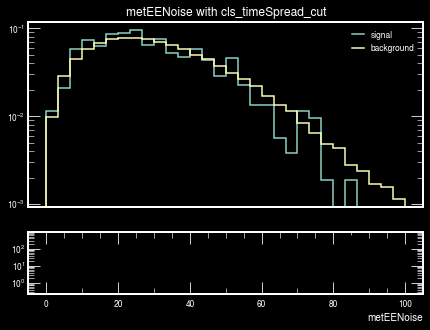

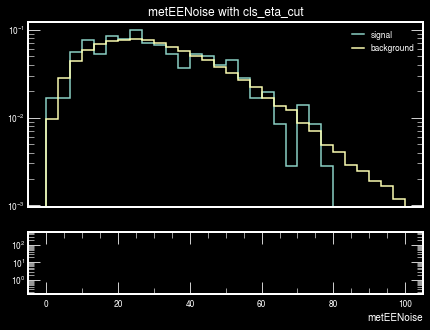

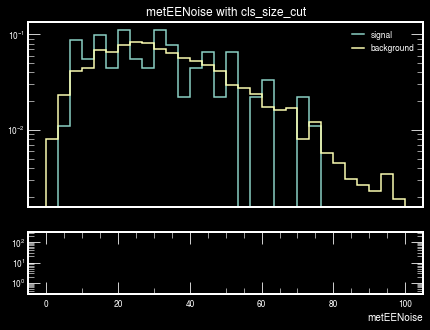

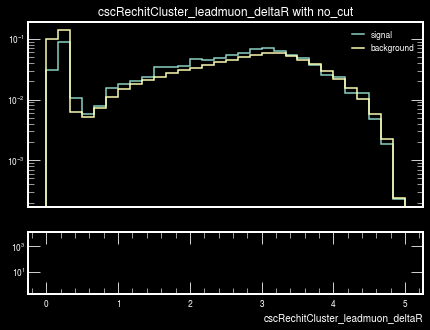

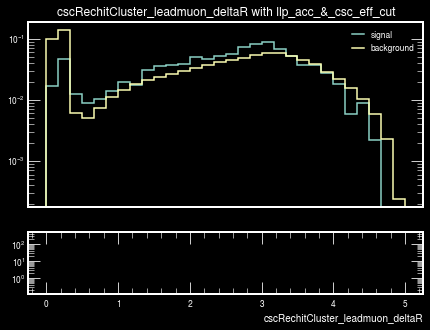

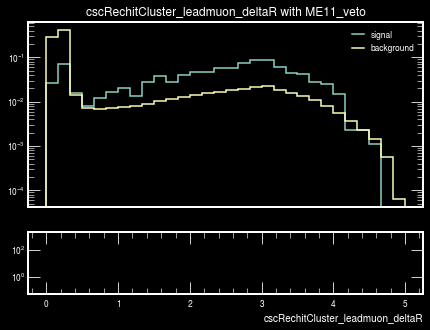

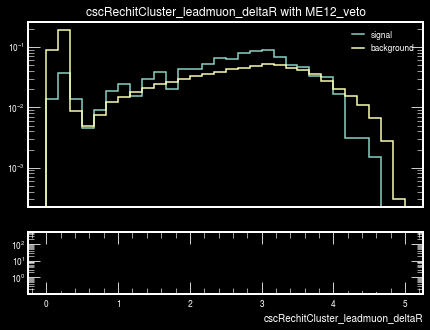

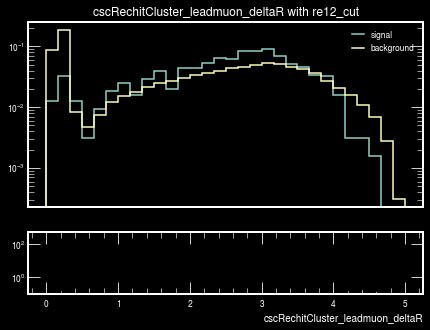

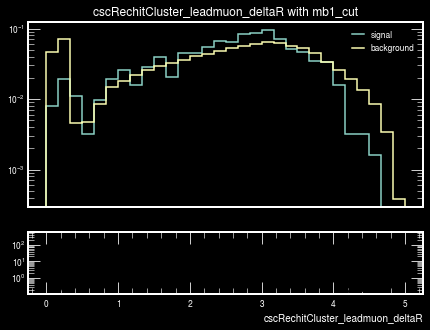

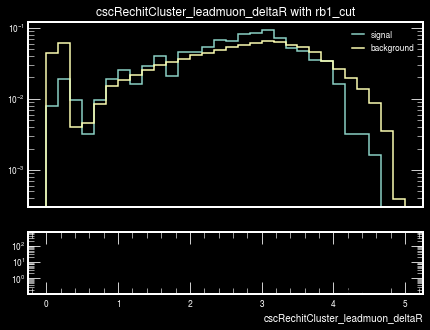

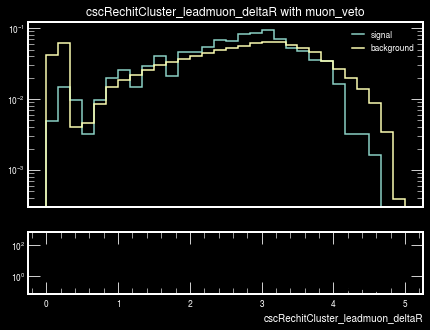

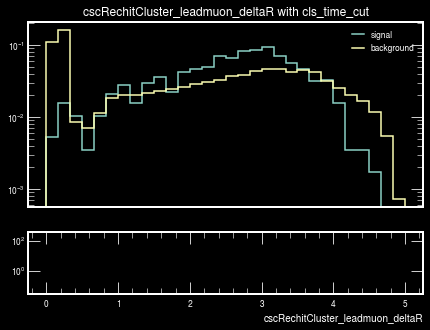

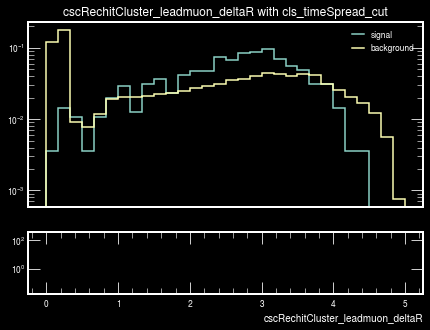

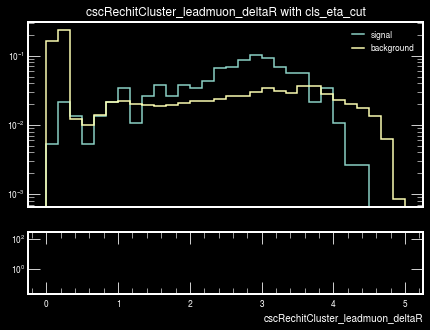

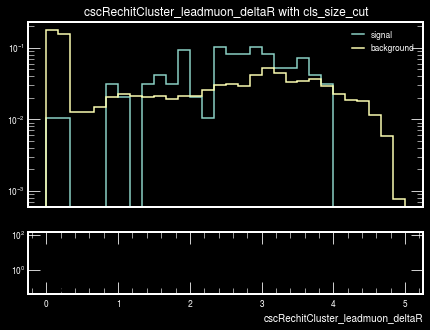

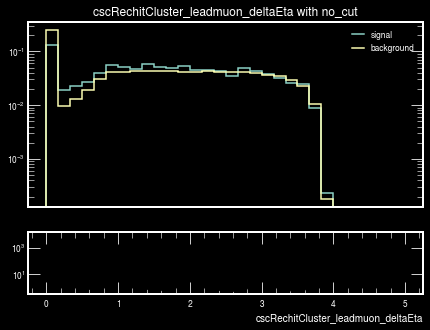

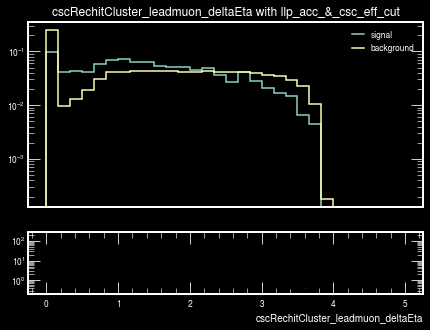

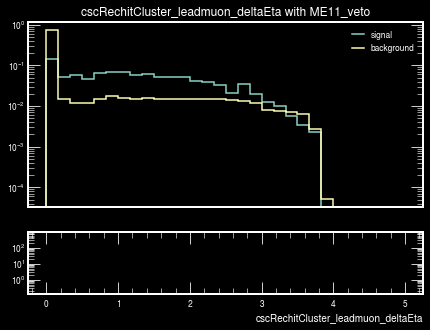

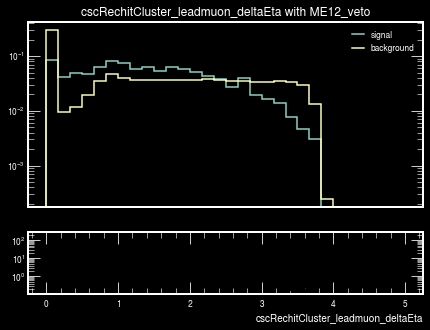

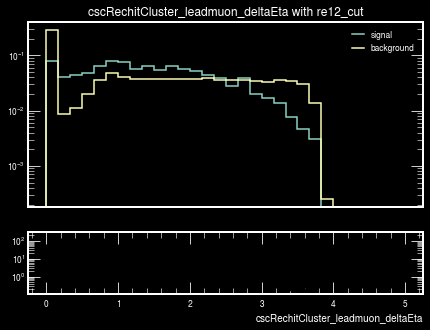

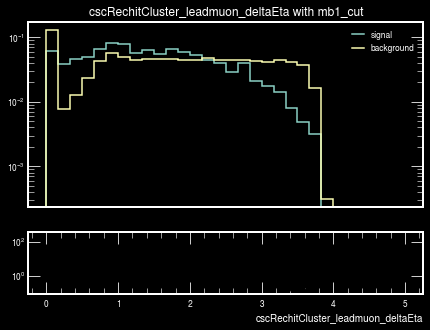

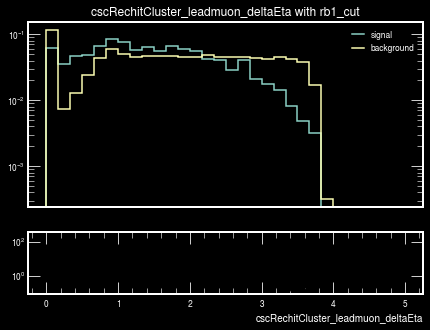

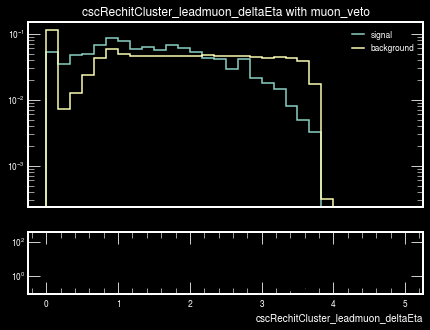

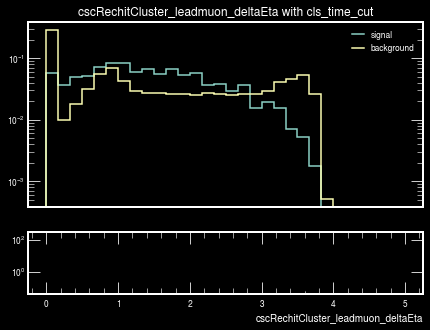

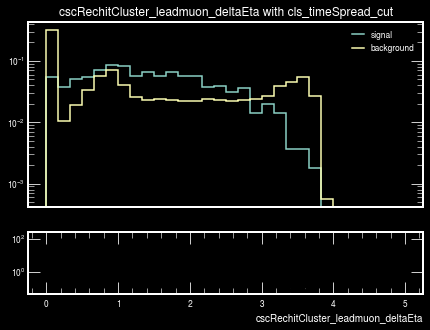

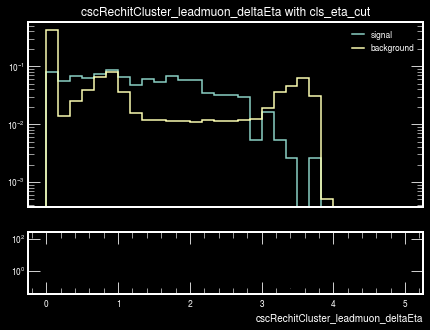

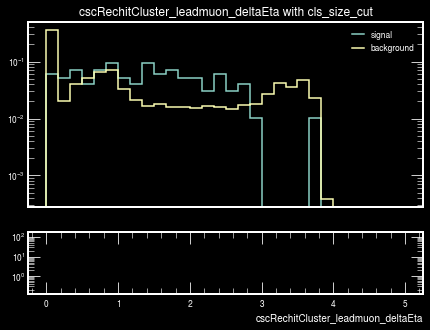

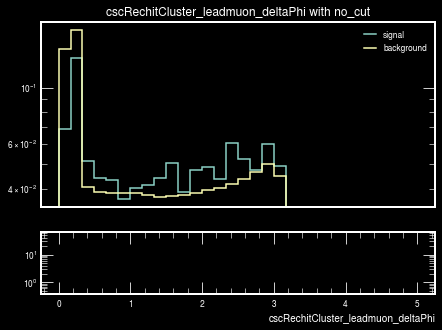

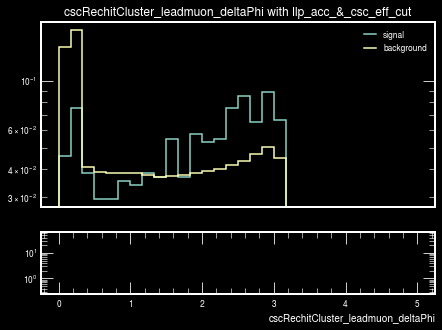

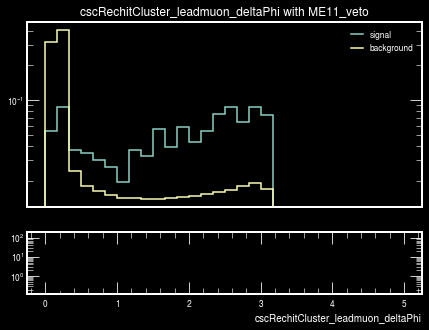

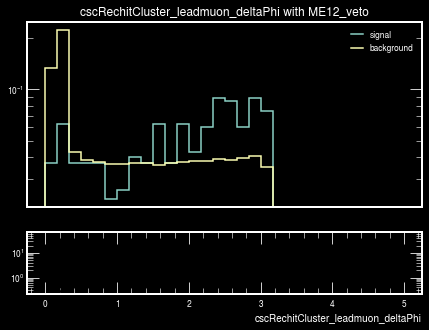

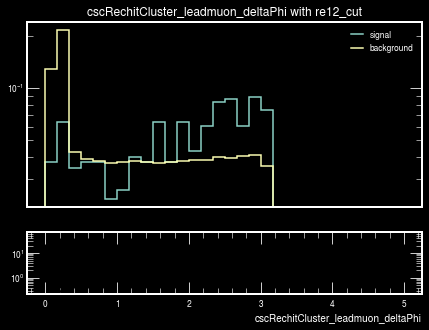

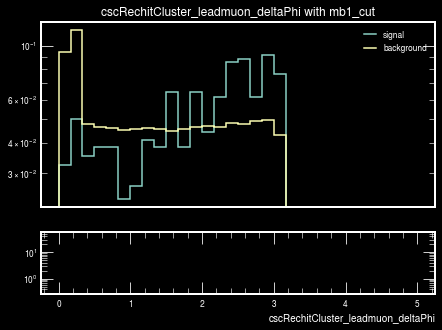

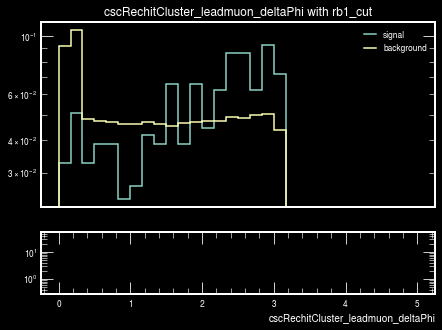

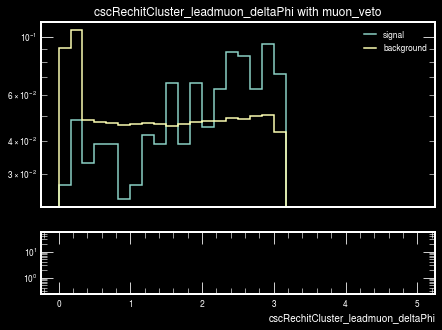

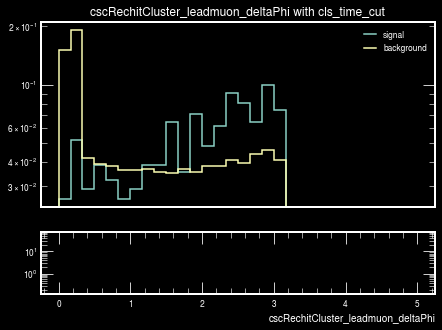

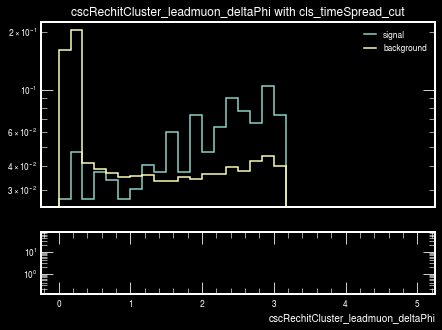

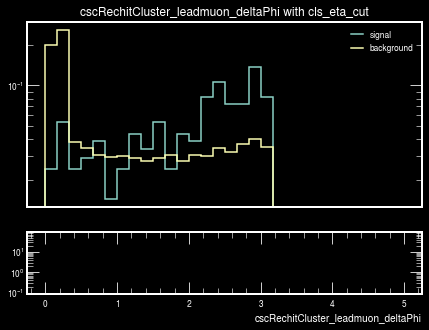

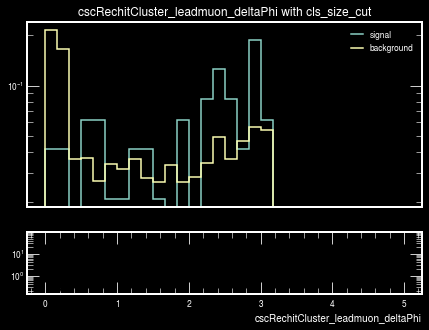

In [47]:
date = today.strftime("%m_%d_%y")
for var in bkgvars:
    pdf = PdfPages(f'varPlots_sb_{date}/{var}_cutflow_sb.pdf')
    for cut in bkgcuts:
        fig = sb_plotter(var, cut);
        pdf.savefig(fig)

    pdf.close()

In [137]:
def ratio(varname, cut, ax):
    
    signal = out['signal'][f'{varname} with {cut}']
    background = out['background'][f'{varname} with {cut}']
    num = signal/signal.sum()
    den = background/background.sum()
    
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax

def sb_plotter(varname, cut, ax):
    signal = out['signal'][f'{varname} with {cut}']
    background = out['background'][f'{varname} with {cut}']

    hep.histplot(signal/signal.sum(), label='signal', ax=ax)
    hep.histplot(background/background.sum(), label='background', ax=ax)
    ax.set_title(f'{varname} with {cut}')
    ax.legend()
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.set(xlabel=None)
    ax.set_yscale('log')
    return ax


def sb_plotter_ratio(varname, cut, ax):
    ax[0] = sb_plotter(varname, cut, ax[0])
    ax[1] = ratio(varname, cut, ax[1])

    ax[1].set_xlim(ax[0].get_xlim())
    #ax[1].set_ylim((0,2))
    ax[1].set(xlabel=varname)
    ax[1].set_yscale('log')
    return ax  
    

/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: divide by zero encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: divide by zero encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: divide by zero encountered in true_divide
  y=num.view() / de

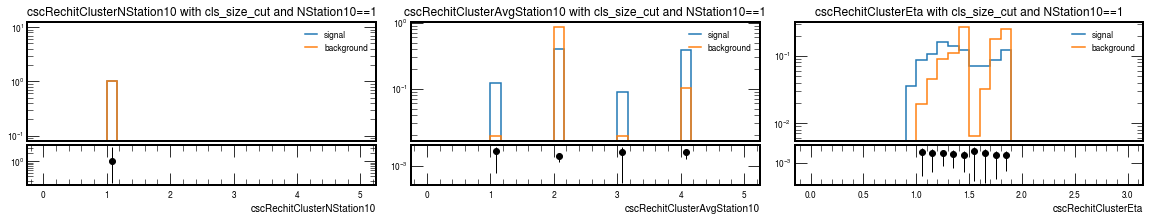

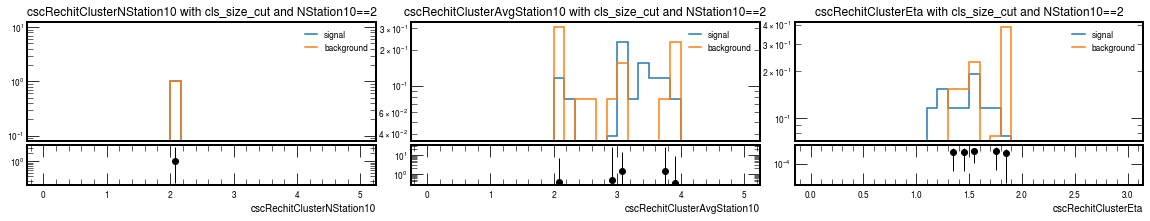

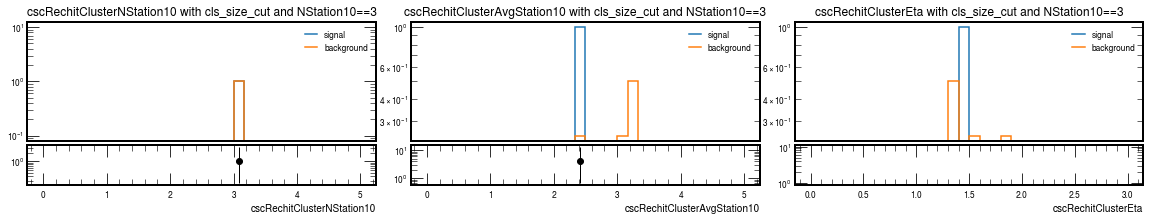

In [175]:
cut = 'cls_size_cut'
for i in range(3):
    fig, ax = plt.subplots(2,3, gridspec_kw={'height_ratios': [3, 1]}, figsize = (20,3))
    fig.subplots_adjust(hspace=.05, wspace=.1)
    sb_plotter_ratio('cscRechitClusterNStation10', f'{cut} and NStation10=={i+1}', [ax[0,0],ax[1,0]])
    sb_plotter_ratio('cscRechitClusterAvgStation10', f'{cut} and NStation10=={i+1}', [ax[0,1],ax[1,1]])
    sb_plotter_ratio('cscRechitClusterEta', f'{cut} and NStation10=={i+1}', [ax[0,2],ax[1,2]])
